## Job Recommender System

The Malaysian job market faces a lack of clear insights into roles, trends, and salaries, making it difficult for job seekers to align their skills and career strategies with industry demands, especially for fresh graduates. This project aims to address these challenges by providing job role recommendations based on factors such as job categories, salaries, locations, languages, and skills. Additionally, it seeks to uncover key trends in job roles, industries, and categories to offer a deeper understanding of the employment landscape in Malaysia.

#### Group 39

**Lecture section: TC1L**

| | Student ID     | Student Name                | Tutorial Section |
|--:|:-------------|:---------------------------:|:----------------:|
| 1 | 1211200755   | Wendy Tan Wei Wei           | TT1L             |
| 2 | 1211202348   | Chan Teng Ee                | TT3L             |
| 3 | 1211103146   | Cheryl Gwee En Xin          | TT3L             |
| 4 | 1211204142   | Jane Heng Jie Ying          | TT3L             |

## Mount Google Drive

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

notebook_path = r"/content/drive/MyDrive/School/ML/Project"
os.chdir(notebook_path)
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/School/ML/Project


# 1.0 Data Preprocessing

## 1.1 Load Data

In [1]:
import pandas as pd
data = pd.read_csv('jobstreet_all_job_dataset.csv')

In [2]:
data.head()

,job_id,job_title,company,descriptions,location,category,subcategory,role,type,salary,listingDate
0,74630583,Procurement Executive (Contract),Coca-Cola Bottlers (Malaysia) Sdn Bhd,Position Purpose\nManage aspects of procuremen...,Negeri Sembilan,"Manufacturing, Transport & Logistics","Purchasing, Procurement & Inventory",procurement-executive,Contract/Temp,NaN,2024-03-21T05:58:35Z
1,74660602,Account Executive/ Assistant,Acoustic & Lighting System Sdn Bhd,We are looking for a Account Executive/ Assist...,Petaling,Accounting,Bookkeeping & Small Practice Accounting,executive-assistant,Full time,"RM 2,800 – RM 3,200 per month",2024-03-22T06:52:57Z
2,74655679,"Data Analyst - Asset Management, SPX Express",Shopee Mobile Malaysia Sdn Bhd,Performs detailed data analysis on existing sp...,Klang District,"Manufacturing, Transport & Logistics",Analysis & Reporting,asset-management-analyst,Full time,NaN,2024-03-22T04:22:43Z
3,74657624,Service Engineer,Sun Medical Systems Sdn Bhd,"You are important for troubleshooting, install...",Petaling,Engineering,Electrical/Electronic Engineering,services-engineer,Full time,"RM 3,000 – RM 3,500 per month",2024-03-22T05:32:09Z
4,74679363,Purchasing Executive,Magnet Security & Automation Sdn. Bhd.,"MAG is a trailblazer in the industry, boasting...",Hulu Langat,"Manufacturing, Transport & Logistics","Purchasing, Procurement & Inventory",purchasing-executive,Full time,"RM 2,800 – RM 3,500 per month",2024-03-23T03:56:39Z


In [3]:
data.shape

(59306, 11)

## 1.2 Handling Missing Value
Checking missing values is a fundamental step in data preprocessing to ensure the accuracy and intergrity of the data. Missing values can cause errors or reduce the performance of models. Hence, this checking step is necessary.

In [4]:
data.isnull().sum()

job_id              0
job_title           0
company             0
descriptions        0
location            0
category            0
subcategory         0
role             1936
type                0
salary          32665
listingDate         0
dtype: int64


From the result given, we can see that there are 1936 missing value rows in 'role' column and 32665 missing value rows in 'salary' column.

Since the dataset is the output of web scraping, the inconsistency in the 'role column' is expected. Web scraping often yields unstructured or semi-structured data, which can lead to missing or inconsistent values. Since the role column contains many unique and inconsistent values, grouping by subcategory provides a more structured way to analyze the missing values.

In [5]:
# Count missing values in 'role' for each 'subcategory'
missing_role_count = data.groupby('subcategory')['role'].apply(lambda x: x.isnull().sum())

# Convert the series to a DataFrame
missing_role_df = missing_role_count.reset_index()
missing_role_df.columns = ['Subcategory', 'Missing Value Count']

# Print all results
print(missing_role_df.to_string(index=False))

                                   Subcategory  Missing Value Count
             Account & Relationship Management                   39
                      Accounts Officers/Clerks                    4
                              Accounts Payable                    3
            Accounts Receivable/Credit Control                    0
                                     Actuarial                    8
                                Administration                    1
                     Administrative Assistants                  181
                         Aerospace Engineering                    5
                     Aged & Disability Support                    0
                     Agency Account Management                    2
                      Agronomy & Farm Services                    1
              Air Conditioning & Refrigeration                    0
                                      Airlines                    0
                          Ambulance/Paramedics  

## 1.3 Fill in the missing value
### Handling "role" column
The role column contains categorical data, and using mode() is the most appropriate measure of central tendency.

In [6]:
def replace_role_mode(group):
    mode_value = group['role'].mode()  # Find the mode of the 'role' column
    if not mode_value.empty:
        group['role'] = group['role'].fillna(mode_value.iloc[0])  # Fill NaN with mode
    return group

# Group by 'subcategory' and apply the function
data = data.groupby('subcategory').apply(replace_role_mode)

In [7]:
data.isnull().sum()

job_id              0
job_title           0
company             0
descriptions        0
location            0
category            0
subcategory         0
role                0
type                0
salary          32665
listingDate         0
dtype: int64


After performing data cleaning and imputation for 'role' column, we can see that there is no missing value.

### Handling "Salary" column

For rows with an empty "salary" column, we replace the missing values with the placeholder "missing." Next, we create a new column named "missing_salary," where a value of 1 indicates missing salary information and 0 indicates otherwise. This allows us to analyze trends, such as identifying which companies are more likely to omit salary details in their job vacancies.

In [8]:
# Replace NaN values in the 'salary' column with 'missing'
data['salary'] = data['salary'].fillna("missing")

# Create the 'salary_missing' column
data['salary_missing'] = data['salary'].apply(lambda x: 1 if x == "missing" else 0)
data['salary_missing'] = data['salary_missing'].astype(bool)

# 2.0 Exploratory Data Analysis (EDA)
## 2.1 Processing "salary" column
The 'salary' data is expressed as range and in text format which is difficult to analyze it for model. It is also consists of inconsistents format such as MYR9k - MYR12k and RM5000-8000. To standardize the salary data and make it useful for analysis, we split the range into 2 new columns which are 'min_salary' and 'max_salary' and converts textual data into numerical value. This ensure the data is consistent and also handle cases where single salary value exists.

In [9]:
import pandas as pd
import re

# Function to clean and process the salary
def clean_salary(salary):
    try:
        # Handle salary with both "MYR" present
        # MYR 1,000 – MYR 2,000
        myr_both = re.search(r'MYR\s?([\d,]+)\s?[-–]\s?MYR\s?([\d,]+)', salary, re.IGNORECASE)
        if myr_both:
            min_salary = float(myr_both.group(1).replace(',', ''))
            max_salary = float(myr_both.group(2).replace(',', ''))
            return min_salary, max_salary

        # Handle salary with only one "MYR" is present
        # MYR 1,000 - 2,000
        myr_one = re.search(r'MYR\s?([\d,]+)\s?[-–]\s?([\d,]+)', salary, re.IGNORECASE)
        if myr_one:
            min_salary = float(myr_one.group(1).replace(',', ''))
            max_salary = float(myr_one.group(2).replace(',', ''))
            return min_salary, max_salary

        # Handle salary with "k" (thousands) and both "MYR" present
        # MYR 9k - MYR 13k
        myr_k = re.search(r'MYR\s?(\d+)(k)?\s?[-–]\s?MYR\s?(\d+)(k)?', salary, re.IGNORECASE)
        if myr_k:
            min_salary = float(myr_k.group(1)) * (1000 if myr_k.group(2) else 1)
            max_salary = float(myr_k.group(3)) * (1000 if myr_k.group(4) else 1)
            return min_salary, max_salary

        # Handle salary range with "MYR" and "per year"
        # From 48000 to 72000 MYR per year
        myr_yearly_range = re.search(r'From\s?([\d,]+)\s?to\s?([\d,]+)\s?MYR\s?per\s?year', salary, re.IGNORECASE)
        if myr_yearly_range:
            min_salary = float(myr_yearly_range.group(1).replace(',', '')) / 12
            max_salary = float(myr_yearly_range.group(2).replace(',', '')) / 12
            return min_salary, max_salary

        # Handle "From X to Y MYR per month"
        # From 3000 to 3500 MYR per month
        from_to_myr = re.search(r'From\s([\d,]+)\s?to\s?([\d,]+)\s?MYR', salary, re.IGNORECASE)
        if from_to_myr:
            min_salary = float(from_to_myr.group(1).replace(',', ''))
            max_salary = float(from_to_myr.group(2).replace(',', ''))
            return min_salary, max_salary

        # Handle "Up to MYR X per annum"
        # Up to MYR 156,000 per annum
        up_to_myr_annum = re.search(r'Up\s?to\s?MYR\s?([\d,]+)\s?per\s?annum', salary, re.IGNORECASE)
        if up_to_myr_annum:
            max_salary = float(up_to_myr_annum.group(1).replace(',', '')) / 12
            return max_salary, max_salary  # Set both min and max to the same value

        # Handle "Up to MYR X"
        # Up to MYR 6000
        up_to_myr = re.search(r'Up\s?to\s?MYR\s?([\d,]+)', salary, re.IGNORECASE)
        if up_to_myr:
            max_salary = float(up_to_myr.group(1).replace(',', ''))
            return max_salary, max_salary

        # Handle salary range with "p.a." (per annum) and convert to monthly
        # RM 10k - RM 15k p.a.
        rm_range_annual = re.search(r'RM\s?([\d,]+)(k)\s?[-–]\s?RM\s?([\d,]+)(k)\s?p\.a\.', salary, re.IGNORECASE)
        if rm_range_annual:
            min_salary = float(rm_range_annual.group(1).replace(',', '')) * 1000 / 12
            max_salary = float(rm_range_annual.group(3).replace(',', '')) * 1000 / 12
            return min_salary, max_salary

        # Handle salary with a single value
        # MYR 14,000
        myr_single_value = re.search(r'MYR\s?([\d,]+)', salary, re.IGNORECASE)
        if myr_single_value:
            single_salary = float(myr_single_value.group(1).replace(',', ''))
            return single_salary, single_salary

        # Handle salary with "$" symbol but ignore it, capture MYR values
        # $12000.00 - $18000.00 MYR
        myr_with_dollar_range = re.search(r'\$([\d,]+(?:\.\d{1,2})?)\s?[-–]\s?\$([\d,]+(?:\.\d{1,2})?)\s?MYR', salary, re.IGNORECASE)
        if myr_with_dollar_range:
            min_salary = float(myr_with_dollar_range.group(1).replace(',', ''))
            max_salary = float(myr_with_dollar_range.group(2).replace(',', ''))
            return min_salary, max_salary

#---------------------------------------------------------------------------------------------------------------------------------------------

        # Handle "RM" salary range with decimal values, "k" and "p.a."
        # RM7000.0 - RM10000.0 p.a.
        rm_range_annual = re.search(r'RM\s?([\d,\.]+)\s?[-–]\s?RM\s?([\d,\.]+)\s?p\.a\.', salary, re.IGNORECASE)
        if rm_range_annual:
            min_salary = float(rm_range_annual.group(1).replace(',', '')) / 12
            max_salary = float(rm_range_annual.group(2).replace(',', '')) / 12
            return min_salary, max_salary

        # Handle "RM" salary range with thousand separator dots and "per month"
        # RM 2.000 – RM 3.000 per month
        rm_dot= re.search(r'RM\s?([\d,\.]+)\s?[-–]\s?RM\s?([\d,\.]+)\s?per\s?month', salary, re.IGNORECASE)
        if rm_dot:
            # Remove dots and commas, then convert to integer
            min_salary = int(rm_dot.group(1).replace('.', '').replace(',', ''))
            max_salary = int(rm_dot.group(2).replace('.', '').replace(',', ''))
            return min_salary, max_salary

        # Handle "RM" salary range without spaces
        # RM5000-8000
        rm_range_no_space = re.search(r'RM\s?([\d,]+)\s?[-–]\s?([\d,]+)', salary, re.IGNORECASE)
        if rm_range_no_space:
            min_salary = float(rm_range_no_space.group(1).replace(',', ''))
            max_salary = float(rm_range_no_space.group(2).replace(',', ''))
            return min_salary, max_salary

        # Handle salary with both "RM" present
        # RM 1,000 - RM 2,000 per month
        rm_both = re.search(r'RM\s?([\d,]+)\s?[-–]\s?RM\s?([\d,]+)', salary, re.IGNORECASE)
        if rm_both:
            min_salary = int(rm_both.group(1).replace(',', ''))
            max_salary = int(rm_both.group(2).replace(',', ''))
            return min_salary, max_salary

        # Handle salary with "RM" followed by value and "per month"
        # RM 1,000 per month
        rm_per_month = re.search(r'RM\s?([\d,]+)\s?per\s?month', salary, re.IGNORECASE)
        if rm_per_month:
            single_salary = float(rm_per_month.group(1).replace(',', ''))
            return single_salary, single_salary

        # Handle salary range with "RM" and the word "to" between the range
        # RM 6,000 to RM 15,000
        rm_range_to = re.search(r'RM\s?([\d,]+)\s?to\s?RM\s?([\d,]+)', salary, re.IGNORECASE)
        if rm_range_to:
            min_salary = float(rm_range_to.group(1).replace(',', ''))
            max_salary = float(rm_range_to.group(2).replace(',', ''))
            return min_salary, max_salary

        # Handle "Up to RM X"
        # Up to RM 16,500
        up_to_rm = re.search(r'Up\s?to\s?RM\s?([\d,]+)', salary, re.IGNORECASE)
        if up_to_rm:
            max_salary = float(up_to_rm.group(1).replace(',', ''))
            return max_salary, max_salary

        # Handle salary range with "RM" and decimal values
        # RM 1,500.20 – RM 2,049.60 per month
        rm_range_decimal = re.search(r'RM\s?([\d,]+(?:\.\d+)?)\s?[-–]\s?RM\s?([\d,]+(?:\.\d+)?)\s?(per\smonth|p\.a\.)?', salary, re.IGNORECASE)
        if rm_range_decimal:
            min_salary = float(rm_range_decimal.group(1).replace(',', ''))
            max_salary = float(rm_range_decimal.group(2).replace(',', ''))
            return min_salary, max_salary

        # Handle salary range with "RM" and "k"
        # RM3k - RM 4500 p.m.
        rm_range_k_pm = re.search(r'RM\s?([\d,]+)(k|K)?\s?[-–]\s?RM\s?([\d,]+)(k|K)?\s?(p\.m\.)?', salary, re.IGNORECASE)
        if rm_range_k_pm:
            min_salary = float(rm_range_k_pm.group(1).replace(',', '')) * (1000 if rm_range_k_pm.group(2) else 1)
            max_salary = float(rm_range_k_pm.group(3).replace(',', '')) * (1000 if rm_range_k_pm.group(4) else 1)
            return min_salary, max_salary

        # Handle "RM" salary range with decimal values and "k"
        # RM3.5k - RM5.3k
        rm_range_k_decimal = re.search(r'RM\s?([\d,\.]+)(k)\s?[-–]\s?RM\s?([\d,\.]+)(k)', salary, re.IGNORECASE)
        if rm_range_k_decimal:
            min_salary = float(rm_range_k_decimal.group(1).replace(',', '')) * 1000
            max_salary = float(rm_range_k_decimal.group(3).replace(',', '')) * 1000
            return min_salary, max_salary

        # Handle single salary with "RM" (e.g., RM 14,000)
        rm_single_value = re.search(r'RM\s?([\d,]+)', salary, re.IGNORECASE)
        if rm_single_value:
            single_salary = float(rm_single_value.group(1).replace(',', ''))
            return single_salary, single_salary

#---------------------------------------------------------------------------------------------------------------------------------------------

        # Handle "SGD" salary range
        # SGD 2,500 - 3,100
        sgd_range = re.search(r'SGD\s?([\d,]+)\s?[-–]\s?([\d,]+)', salary, re.IGNORECASE)
        if sgd_range:
            min_salary_sgd = float(sgd_range.group(1).replace(',', '')) * 3.3
            max_salary_sgd = float(sgd_range.group(2).replace(',', '')) * 3.3
            return min_salary_sgd, max_salary_sgd

        # Handle "SGD" salary
        # SGD 5700 per month
        sgd_single_value = re.search(r'SGD\s?([\d,]+)\s?(per\s?month)?', salary, re.IGNORECASE)
        if sgd_single_value:
            min_salary_sgd = float(sgd_single_value.group(1).replace(',', '')) * 3.3
            return min_salary_sgd, min_salary_sgd

#---------------------------------------------------------------------------------------------------------------------------------------------

        # Handle "$" salary range with dots as thousands separator
        # $3.000 – $4.500 per month
        usd_range_dots = re.search(r'\$(\d{1,3}(?:\.\d{3})*)\s?–\s?\$(\d{1,3}(?:\.\d{3})*)\s?per\s?month', salary, re.IGNORECASE)
        if usd_range_dots:
            min_salary_usd = float(usd_range_dots.group(1).replace('.', '').replace(',', '')) * 4.5  # Convert USD to MYR
            max_salary_usd = float(usd_range_dots.group(2).replace('.', '').replace(',', '')) * 4.5  # Convert USD to MYR
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with decimals and 'k'
        # $7000.0 - $9k p.m. + Contractual bonus
        usd_range_decimal_k = re.search(r'\$(\d+(\.\d+)?)\s?-\s?\$(\d+)(k)\s?p\.m\.\s?\+?.*', salary, re.IGNORECASE)
        if usd_range_decimal_k:
            min_salary_usd = float(usd_range_decimal_k.group(1)) * 4.5
            max_salary_usd = float(usd_range_decimal_k.group(3)) * 1000 * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with 'k' and decimals
        # $18k - $20000.00 p.m.
        usd_range_k_decimal = re.search(r'\$(\d+)(k)\s?-\s?\$(\d+(\.\d{2})?)\s?p\.m\.', salary, re.IGNORECASE)
        if usd_range_k_decimal:
            min_salary_usd = float(usd_range_k_decimal.group(1)) * 1000 * 4.5
            max_salary_usd = float(usd_range_k_decimal.group(3)) * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "$40,000 – $45,000 per year" pattern
        # $40,000 – $45,000 per year
        usd_range_per_year = re.search(r'\$(\d{1,3}(?:,\d{3})?)\s?[-–]\s?\$(\d{1,3}(?:,\d{3})?)\s?per\s?year', salary, re.IGNORECASE)
        if usd_range_per_year:
            min_salary_usd = float(usd_range_per_year.group(1).replace(',', '')) * 4.5 / 12  # Convert USD to MYR, divided by 12 for monthly
            max_salary_usd = float(usd_range_per_year.group(2).replace(',', '')) * 4.5 / 12
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with "k" and full numeric values in "p.m."
        usd_mixed_pm = re.search(r'\$(\d+)(k)?\s?[-–]\s?\$(\d+)(k)?\s?p\.m\.', salary, re.IGNORECASE)
        if usd_mixed_pm:
            min_salary_usd = float(usd_mixed_pm.group(1)) * (1000 if usd_mixed_pm.group(2) else 1) * 4.5
            max_salary_usd = float(usd_mixed_pm.group(3)) * (1000 if usd_mixed_pm.group(4) else 1) * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with decimal values and "p.m."
        # $3k - $4100 p.m.
        usd_decimal_pm = re.search(r'\$(\d+(\.\d+)?)\s?[-–]\s?\$(\d+(\.\d+)?)\s?p\.m\.', salary, re.IGNORECASE)
        if usd_decimal_pm:
            min_salary_usd = float(usd_decimal_pm.group(1).replace(',', '')) * 4.5
            max_salary_usd = float(usd_decimal_pm.group(3).replace(',', '')) * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with decimal values and "p.m."
        # $10000.0 - $12000.0 p.m.
        usd_decimal_pm = re.search(r'\$(\d+(\.\d+)?)\s?[-–]\s?\$(\d+(\.\d+)?)\s?p\.m\.', salary, re.IGNORECASE)
        if usd_decimal_pm:
            min_salary_usd = float(usd_decimal_pm.group(1).replace(',', '')) * 4.5
            max_salary_usd = float(usd_decimal_pm.group(3).replace(',', '')) * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range
        # $36k - $64k p.a. + Bonus + Other benefits
        usd_range = re.search(r'\$(\d+)(k)\s?[-–]\s?\$(\d+)(k)\s?p\.a\.\s?\+?.*', salary, re.IGNORECASE)
        if usd_range:
            min_salary_usd = float(usd_range.group(1)) * 1000 * 4.5 / 12
            max_salary_usd = float(usd_range.group(3)) * 1000 * 4.5 / 12
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with decimals
        # $8000.00 - $10000.00 p.a.
        usd_range_decimal = re.search(r'\$(\d+(\.\d+)?)\s?[-–]\s?\$(\d+(\.\d+)?)\s?p\.a\.', salary, re.IGNORECASE)
        if usd_range_decimal:
            min_salary_usd = float(usd_range_decimal.group(1)) * 4.5 / 12
            max_salary_usd = float(usd_range_decimal.group(3)) * 4.5 / 12
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with "p.m." and additional text
        # $6k - $10k p.m. + Competitive, Great Exposure
        usd_range_text = re.search(r'\$(\d+)(k)\s?[-–]\s?\$(\d+)(k)\s?p\.m\.', salary, re.IGNORECASE)
        if usd_range_text:
            min_salary_usd = float(usd_range_text.group(1)) * 1000 * 4.5
            max_salary_usd = float(usd_range_text.group(3)) * 1000 * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with "p.m."
        # $5800 - $7500 p.m.
        usd_range_pm = re.search(r'\$(\d+)\s?[-–]\s?\$(\d+)\s?p\.m\.', salary, re.IGNORECASE)
        if usd_range_pm:
            min_salary_usd = float(usd_range_pm.group(1)) * 4.5
            max_salary_usd = float(usd_range_pm.group(2)) * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with decimal and "p.m."
        # $11000.00 - $14000.00 p.m.
        usd_decimal_pm = re.search(r'\$(\d+(\.\d{2})?)\s?[-–]\s?\$(\d+(\.\d{2})?)\s?p\.m\.', salary, re.IGNORECASE)
        if usd_decimal_pm:
            min_salary_usd = float(usd_decimal_pm.group(1).replace(',', '')) * 4.5
            max_salary_usd = float(usd_decimal_pm.group(3).replace(',', '')) * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "$" salary range with "per month"
        # $4,000 – $6,000 per month
        usd_both = re.search(r'\$(\d{1,3}(?:,\d{3})*)\s?[-–]\s?\$(\d{1,3}(?:,\d{3})*)\s?per\s?month', salary, re.IGNORECASE)
        if usd_both:
            min_salary_usd = float(usd_both.group(1).replace(',', '')) * 4.5
            max_salary_usd = float(usd_both.group(2).replace(',', '')) * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "Up to $X p.m."
        # Up to  $8000.0 p.m.
        usd_up_to_pm = re.search(r'Up\s?to\s?\$(\d+(\.\d+)?)(k)?\s?p\.m\.', salary, re.IGNORECASE)
        if usd_up_to_pm:
            max_salary_usd = float(usd_up_to_pm.group(1)) * (1000 if usd_up_to_pm.group(3) else 1) * 4.5
            return max_salary_usd, max_salary_usd

        # Handle "$X - $Y monthly"
        # $20k - $25k
        usd_range_monthly = re.search(r'\$(\d+)(k)?\s?[-–]\s?\$(\d+)(k)?\s?monthly', salary, re.IGNORECASE)
        if usd_range_monthly:
            min_salary_usd = float(usd_range_monthly.group(1)) * (1000 if usd_range_monthly.group(2) else 1) * 4.5
            max_salary_usd = float(usd_range_monthly.group(3)) * (1000 if usd_range_monthly.group(4) else 1) * 4.5
            return min_salary_usd, max_salary_usd

        # Handle "$X.XX - $Y.YY"
        usd_range_decimal = re.search(r'\$(\d+(\.\d{2})?)\s?[-–]\s?\$(\d+(\.\d{2})?)', salary, re.IGNORECASE)
        if usd_range_decimal:
            min_salary_usd = float(usd_range_decimal.group(1)) * 4.5
            max_salary_usd = float(usd_range_decimal.group(3)) * 4.5
            return min_salary_usd, max_salary_usd

#---------------------------------------------------------------------------------------------------------------------------------------------

        # Handle salary range without currency
        # 3500 - 7500
        range_no_currency = re.search(r'(\d+)\s?[-–]\s?(\d+)', salary)
        if range_no_currency:
            min_salary = float(range_no_currency.group(1).replace(',', ''))
            max_salary = float(range_no_currency.group(2).replace(',', ''))
            return min_salary, max_salary

        # Handle single salary value without currency symbol
        # 6,000
        single_no_currency = re.search(r'(\d{1,3}(?:,\d{3})*)', salary)
        if single_no_currency:
            single_salary = float(single_no_currency.group(1).replace(',', ''))
            return single_salary, single_salary


    except Exception as e:
        pass

    return None, None  # Ensure function always returns two values


# clean_salary function returns a tuple
# .apply(pd.Series) "splits" each tuple into separate columns
data[['min_salary', 'max_salary']] = data['salary'].apply(clean_salary).apply(pd.Series)


### Fill in missing value in min_salary and max_salary

To handle missing values in the 'min_salary' and 'max_salary' columns, we imputed them with the mean salary values for their respective subcategory. By doing so, it is to avoid introducing bias that could happen if we used one average for all groups.

In [10]:
# Ensure 'subcategory' is only a column
data = data.reset_index(drop=True)

# Compute the mean for min_salary and max_salary within each subcategory
mean_salary = data.groupby('subcategory')[['min_salary', 'max_salary']].mean()

# Define a function to fill missing values based on the mean of the subcategory
def replace_salary_mean(row):
    subcategory = row['subcategory']
    if subcategory in mean_salary.index:
        if pd.isnull(row['min_salary']):
            row['min_salary'] = mean_salary.loc[subcategory, 'min_salary']
        if pd.isnull(row['max_salary']):
            row['max_salary'] = mean_salary.loc[subcategory, 'max_salary']
    return row


# Apply the function row-wise
data = data.apply(replace_salary_mean, axis=1)

# Round 'min_salary' and 'max_salary' to 2 decimal places
data['min_salary'] = data['min_salary'].round(2)
data['max_salary'] = data['max_salary'].round(2)

In [11]:
data.isnull().sum()

job_id             0
job_title          0
company            0
descriptions       0
location           0
category           0
subcategory        0
role               0
type               0
salary             0
listingDate        0
salary_missing     0
min_salary        42
max_salary        42
dtype: int64


Based on the output given, there is still missing value occurs in 'min_salary' and 'max_salary' columns, with 42 missing entries each. This occurs because some job listings did not include salary information. As a result, when the salary data was split into min_salary and max_salary, these missing values were carried over, resulting in NaN values in both columns.

Since salary data is critical for our analysis, we removed rows where 'min_salary' and 'max_salary' is missing. This ensures that the dataset used for analysis or modeling contains complete salary data.

In [12]:
# Drop rows where 'min_salary' or 'max_salary' is NaN
data = data.dropna(subset=['min_salary', 'max_salary'])

In [13]:
data.isnull().sum()

job_id            0
job_title         0
company           0
descriptions      0
location          0
category          0
subcategory       0
role              0
type              0
salary            0
listingDate       0
salary_missing    0
min_salary        0
max_salary        0
dtype: int64

In [14]:
data.shape

(59264, 14)

The dataset now consists of 59264 rows and 14 columns after data cleaning process.

## Extract information from "salary"
### Bonus Count

The 'salary' column contains mentions of bonuses in some entries. To identify and extract this information, a function (check_bonus) is created to check if the word 'bonus' appears in the salary field. The result is stored in a new column called 'bonus', which converted to a boolean data type (True for bonus, False for no bonus). This step allows for easy filtering and analysis of job listings that include bonuses since bonuses are a significant part of compensation and influence job attractiveness. It helps to identify industries or roles that frequently offer bonus and know which industries or roles offer bonuses helps job seekers find roles with better pay options.

In [15]:
def check_bonus(salary):
    if 'bonus' in str(salary).lower():
        return 1 # 1 indicates there is a bonus
    else:
        return 0 # 0 indicates there is no bonus

# Apply the function to the 'salary' column and create a new 'bonus' column
data['bonus'] = data['salary'].apply(check_bonus)
data['bonus'] = data['bonus'].astype(bool)

### Work From Home Count

Work from home has become popular after COVID19 pandemic, hence, this has become a significant factor for job seekers. To identify job listings that offer work from home, a function (check_work_from_home) is created to check if the word 'home' appears in the salary field. The result is stored in a new column called 'work_from_home', which converted to a boolean data type (True for work-from-home, False for no work-from-home). Counting how often jobs allow WFH helps job seekers choose jobs that fit their lifestyle. This also provides insights into which industries or roles are more likely to offer remote work opportunities.

In [16]:
def check_work_from_home(salary):
    if 'home' in str(salary).lower():
        return 1  # 1 indicates "home" is mentioned
    else:
        return 0  # 0 indicates "home" is not mentioned

data['work_from_home'] = data['salary'].apply(check_work_from_home)
data['work_from_home'] = data['work_from_home'].astype(bool)

### Hybrid Count

Hybrid work means combinining working from home and physically attending the office, have become increasingly popular as they offer flexibility for employees. To identify job listings that offer hybrid work options, a function (check_hybrid) is created to check if the word 'hybrid' appears in the 'salary' column. Counting hybrid roles shows how many jobs offer this flexibility. The result is stored in a new column called 'hybrid', which converted to a boolean data type (True for hybrid, False for no hybrid). Counting how often jobs offer hybrid work helps job seekers find roles that let them work both from home and in the office, giving them more flexibility.

In [17]:
def check_hybrid(salary):
    if 'hybrid' in str(salary).lower():
        return 1  # 1 indicates "hybrid" is mentioned
    else:
        return 0  # 0 indicates "hybrid" not mentioned

data['hybrid'] = data['salary'].apply(check_hybrid)
data['hybrid'] = data['hybrid'].astype(bool)

## 2.2 Data Transformation

The listingDate format is (Date)(Timezone) so we need to convert into (Date) for simplification. Not only that, this step also ensures that all dates are uniform, making it easier to sort, filter, and analyze the data.

In [18]:
data['listingDate'] = pd.to_datetime(data['listingDate']).dt.strftime('%Y-%m-%d')

## 2.3 Data Discretization

Grouping many small districts or locations into states to simplify the analysis. Furthermore, treating the locations as states rather than individual cities allows the model to generalize better.

In [19]:
print(data['location'].unique())

['Sarawak' 'Kepong' 'Selangor' 'Kuala Lumpur' 'Penang' 'Klang District'
 'Shah Alam/Subang' 'Kota Kinabalu District' 'Petaling' 'Kedah' 'Melaka'
 'Bangsar South' 'Kuala Lumpur Sentral' 'Alam Damai' 'Kuchai Lama'
 'Johor Bahru District' 'Johor' 'Kuala Lumpur City Centre' 'Perak'
 'Seberang Perai' 'Pahang' 'Taman Tun Dr Ismail' 'Hulu Langat'
 'Kota Bharu District' 'Klang/Port Klang' 'Seremban District'
 'Penang Island' 'Kuantan District' 'Melaka Tengah' 'Mont Kiara'
 'Kampung Malaysia Raya' 'Bukit Damansara' 'Kajang/Bangi/Serdang'
 'Negeri Sembilan' 'Muar District' 'Kinta District' 'Others'
 'Mid Valley City' 'Kluang District' 'Tun Razak Exchange' 'Sabah'
 'Sandakan District' 'Miri Division' 'Sibu Division' 'Taman Connaught'
 'Cheras' 'Bandar Malaysia' 'Bintulu Division' 'Kota Tinggi District'
 'Taman Bukit Maluri' 'Kuching Division' 'Sri Hartamas' 'Kepong Baru'
 'Kuala Muda' 'Kelantan' 'Gombak District' 'Wangsa Maju' 'Kulai District'
 'Bukit Jalil' 'Malaysia' 'Bangsar' 'Terengganu' 'Bat

From the results above, the 'location' column originally contained a mix of districts, cities, and states.

To standardize the data, a dictionary (location_to_state) is created to map each district or city to its corresponding state. A new column called 'state' is created to simplify the dataset and ensure data consistency.

In [20]:
# Create a dictionary mapping locations to states
location_to_state = {
    'Sarawak': 'Sarawak',
    'Kepong': 'Wilayah Persekutuan',
    'Selangor': 'Selangor',
    'Kuala Lumpur': 'Wilayah Persekutuan',
    'Penang': 'Penang',
    'Klang District': 'Selangor',
    'Shah Alam/Subang': 'Selangor',
    'Kota Kinabalu District': 'Sabah',
    'Petaling': 'Selangor',
    'Kedah': 'Kedah',
    'Melaka': 'Melaka',
    'Bangsar South': 'Wilayah Persekutuan',
    'Kuala Lumpur Sentral': 'Wilayah Persekutuan',
    'Alam Damai': 'Wilayah Persekutuan',
    'Kuchai Lama': 'Wilayah Persekutuan',
    'Johor Bahru District': 'Johor',
    'Johor': 'Johor',
    'Kuala Lumpur City Centre': 'Wilayah Persekutuan',
    'Perak': 'Perak',
    'Seberang Perai': 'Penang',
    'Pahang': 'Pahang',
    'Taman Tun Dr Ismail': 'Wilayah Persekutuan',
    'Hulu Langat': 'Selangor',
    'Kota Bharu District': 'Kelantan',
    'Klang/Port Klang': 'Selangor',
    'Seremban District': 'Negeri Sembilan',
    'Penang Island': 'Penang',
    'Kuantan District': 'Pahang',
    'Melaka Tengah': 'Melaka',
    'Mont Kiara': 'Wilayah Persekutuan',
    'Kampung Malaysia Raya': 'Selangor',
    'Bukit Damansara': 'Selangor',
    'Kajang/Bangi/Serdang': 'Selangor',
    'Negeri Sembilan': 'Negeri Sembilan',
    'Muar District': 'Johor',
    'Kinta District': 'Perak',
    'Others': 'Others',
    'Mid Valley City': 'Wilayah Persekutuan',
    'Kluang District': 'Johor',
    'Tun Razak Exchange': 'Wilayah Persekutuan',
    'Sabah': 'Sabah',
    'Sandakan District': 'Sabah',
    'Miri Division': 'Sarawak',
    'Sibu Division': 'Sarawak',
    'Taman Connaught': 'Wilayah Persekutuan',
    'Cheras': 'Wilayah Persekutuan',
    'Bandar Malaysia': 'Wilayah Persekutuan',
    'Bintulu Division': 'Sarawak',
    'Kota Tinggi District': 'Johor',
    'Taman Bukit Maluri': 'Wilayah Persekutuan',
    'Kuching Division': 'Sarawak',
    'Sri Hartamas': 'Wilayah Persekutuan',
    'Kepong Baru': 'Wilayah Persekutuan',
    'Kuala Muda': 'Selangor',
    'Kelantan': 'Kelantan',
    'Gombak District': 'Selangor',
    'Wangsa Maju': 'Wilayah Persekutuan',
    'Kulai District': 'Johor',
    'Bukit Jalil': 'Wilayah Persekutuan',
    'Malaysia': 'Malaysia',
    'Bangsar': 'Wilayah Persekutuan',
    'Terengganu': 'Terengganu',
    'Batu Pahat District': 'Johor',
    'Gua Musang': 'Kelantan',
    'Kulim District': 'Kedah',
    'Kuala Terengganu District': 'Terengganu',
    'Manjung District': 'Perak',
    'Kota Setar': 'Kedah',
    'Putrajaya': 'Wilayah Persekutuan',
    'Kuala Selangor District': 'Selangor',
    'Pontian': 'Johor',
    'Sepang': 'Selangor',
    'Tawau District': 'Sabah',
    'Keningau District': 'Sabah',
    'Bukit Bintang': 'Wilayah Persekutuan',
    'Temerloh District': 'Pahang',
    'Tanah Merah': 'Kelantan',
    'Perak Tengah District': 'Perak',
    'Kuala Langat': 'Selangor',
    'Larut, Matang and Selama District': 'Perak',
    'Langkawi': 'Kedah',
    'Machang': 'Kelantan',
    'Pasir Puteh': 'Kelantan',
    'Penampang District': 'Sabah',
    'Lahad Datu District': 'Sabah',
    'Port Dickson District': 'Negeri Sembilan',
    'KL Eco City': 'Wilayah Persekutuan',
    'Setiawangsa': 'Wilayah Persekutuan',
    'Bandar Sri Permaisuri': 'Wilayah Persekutuan',
    'Segamat District': 'Johor',
    'Setapak': 'Wilayah Persekutuan',
    'Hulu Selangor': 'Selangor',
    'Bentong District': 'Pahang',
    'Titiwangsa': 'Wilayah Persekutuan',
    'Maluri': 'Wilayah Persekutuan',
    'Segambut': 'Wilayah Persekutuan',
    'Desa Parkcity': 'Wilayah Persekutuan',
    'Kuala Kangsar District': 'Perak',
    'Ampang': 'Wilayah Persekutuan',
    'Sentul Pasar': 'Wilayah Persekutuan',
    'Taman Desa': 'Wilayah Persekutuan',
    'Pusat Bandar Damansara': 'Wilayah Persekutuan',
    'Sri Petaling': 'Wilayah Persekutuan',
    'Bandar Tasik Selatan': 'Wilayah Persekutuan',
    'Jalan Ipoh': 'Wilayah Persekutuan',
    'Sipitang District': 'Sabah',
    'Pudu': 'Wilayah Persekutuan',
    'Labuan': 'Wilayah Persekutuan',
    'Jempol District': 'Negeri Sembilan',
    'Kampar District': 'Perak',
    'Dungun': 'Terengganu',
    'Alor Gajah District': 'Melaka',
    'Taman OUG': 'Wilayah Persekutuan',
    'Besut': 'Terengganu',
    'Sentul': 'Wilayah Persekutuan',
    'Pekan District': 'Pahang',
    'Serian Division': 'Sarawak',
    'Bandar Menjalara': 'Wilayah Persekutuan',
    'Brickfields': 'Wilayah Persekutuan',
    'Pantai Dalam': 'Wilayah Persekutuan',
    'Chow Kit': 'Wilayah Persekutuan',
    'Seputeh': 'Wilayah Persekutuan',
    'Pandan Perdana': 'Selangor',
    'Raub District': 'Pahang',
    'Sarikei Division': 'Sarawak',
    'Hilir Perak District': 'Perak',
    'Kubang Pasu': 'Kedah',
    'Kemaman': 'Pahang',
    'Taman Midah': 'Wilayah Persekutuan',
    'Pendang District': 'Kedah',
    'Sungai Besi': 'Wilayah Persekutuan',
    'Taman Danau Desa': 'Wilayah Persekutuan',
    'Baling District': 'Kedah',
    'Hulu Terengganu': 'Terengganu',
    'Sabak Bernam': 'Selangor',
    'Ranau District': 'Sabah',
    'Bandar Baharu': 'Kedah',
    'Kapit Division': 'Sarawak',
    'Jelebu District': 'Negeri Sembilan',
    'Lipis': 'Pahang',
    'Putatan District': 'Sabah',
    'Kerian District': 'Perak',
    'Mukah Division': 'Sarawak',
    'Jasin District': 'Melaka',
    'Batang Padang District': 'Perak',
    'Rembau District': 'Negeri Sembilan',
    'Kunak District': 'Sabah',
    'Limbang Division': 'Sarawak',
    'Marang District': 'Terengganu',
    'Shamelin Perkasa': 'Wilayah Persekutuan',
    'Salak South': 'Wilayah Persekutuan',
    'Cameron Highlands': 'Pahang',
    'Bangsar Baru': 'Wilayah Persekutuan',
    'Taman Wahyu': 'Wilayah Persekutuan',
    'Tampin District': 'Negeri Sembilan',
    'Muallim District': 'Perak',
    'Kuala Pilah District': 'Negeri Sembilan',
    'Rompin': 'Pahang',
    'Kudat District': 'Sabah',
    'Happy Garden': 'Wilayah Persekutuan',
    'Tuaran District': 'Sabah',
    'Kangar': 'Perlis',
    'Sri Aman Division': 'Sarawak',
    'Jerantut District': 'Pahang',
    'Tangkak District': 'Johor',
    'Bandar Baru Sentul': 'Wilayah Persekutuan',
    'Medan Tuanku': 'Wilayah Persekutuan',
    'Desa Petaling': 'Wilayah Persekutuan',
    'Kampung Pandan': 'Wilayah Persekutuan',
    'Kampung Baru': 'Wilayah Persekutuan',
    'Kota Marudu District': 'Sabah',
    'Semporna District': 'Sabah',
    'Lembah Keramat': 'Wilayah Persekutuan',
    'Beaufort District': 'Sabah',
    'Taman United': 'Wilayah Persekutuan',
    'Mersing District': 'Johor',
    'Setiu': 'Terengganu',
    'Samarahan Division': 'Sarawak',
    'Perlis': 'Perlis',
    'Maran District': 'Pahang',
    'Papar District': 'Sabah',
    'Beluran District': 'Sabah',
    'Sik District': 'Kedah',
    'Kuala Nerus District': 'Terengganu',
    'Pasir Mas District': 'Kelantan',
    'Hulu Perak District': 'Perak',
    'Kota Belud District': 'Sabah',
    'Bukit Kiara': 'Wilayah Persekutuan',
    'Bera': 'Pahang',
    'Bagan Datuk District': 'Perak',
    'Tanjung Bungah/Teluk Bahang': 'Penang',
    'Tumpat': 'Kelantan',
    'Bachok': 'Kelantan',
    'Yan District': 'Kedah',
    'Gombak Setia': 'Selangor',
    'Wangsa Melawati': 'Wilayah Persekutuan',
    'Taman Len Seng': 'Wilayah Persekutuan',
    'Padang Besar': 'Perlis',
    'Jalan Cochrane': 'Wilayah Persekutuan',
    'Bukit Tunku': 'Wilayah Persekutuan',
    'Kampung Sungai Penchala': 'Wilayah Persekutuan',
    'Taman Sri Sinar': 'Wilayah Persekutuan',
    'Betong Division': 'Sarawak',
    'Jeli District': 'Kelantan'
}

# Apply the dictionary to create a new 'state' column based on the location
data['state'] = data['location'].map(location_to_state)

In [21]:
print(data['state'].unique())

['Sarawak' 'Wilayah Persekutuan' 'Selangor' 'Penang' 'Sabah' 'Kedah'
 'Melaka' 'Johor' 'Perak' 'Pahang' 'Kelantan' 'Negeri Sembilan' 'Others'
 'Malaysia' 'Terengganu' 'Perlis']



After applying the mapping, the location column now contains only state-level information.

## 2.4 Processing descriptions column

There are many informations we can extract from the "descriptions" column. However, every companies write their description differently, hence carefully data extraction is important.

In [23]:
data['descriptions'].head()

,descriptions
0,Join our dynamic team as a Key Account Executi...
1,Job Description\nWINTOO now is looking at a po...
2,We are hiring Sales Executives for our Industr...
3,Job Descriptions:\n· You will be responsible t...
4,"Responsibilities:\nIn this role, you will resp..."


### Text Cleaning

We will first preprocess the descriptions column. First, we remove special characters, digits, and unnecessary symbols to clean the text. However, we retain certain symbols, such as "+", hyphen (-), and "#", as they could indicate programming languages like C++, C#, etc. Additionally, we convert all text to lowercase to ensure consistency and avoid distinguishing between uppercase and lowercase letters. Besides, we remove the stopwords such as "is", "the", and "are", because those stopwords did not bring meaningful information to the model.

In [24]:
import nltk

nltk.download('punkt')  # For word tokenization
nltk.download('punkt_tab')
nltk.download('stopwords')  # For stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Combined function to clean, tokenize, and remove stopwords
def preprocess_text(text):
    # Remove special characters, digits, and unnecessary symbols
    # Some symbols are remained, such as +, - or # because that might be c++, c#, and more
    text = re.sub(r'[^A-Za-z0-9\s+\-#]', '', text)  # Keep alphabets, numbers, spaces, '+' symbol, hyphen (-), and hash (#)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords using NLTK's list of stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(filtered_tokens)

# Apply the combined function to the "descriptions" column
data['descriptions'] = data['descriptions'].apply(preprocess_text)

# Print the DataFrame with the cleaned "descriptions" column
print(data[['descriptions']])


                                            descriptions
0      join dynamic team key account executive oil ga...
1      job description wintoo looking pool dedicated ...
2      hiring sales executives industrial microbiolog...
3      job descriptions responsible expand business n...
4      responsibilities role responsible developing r...
...                                                  ...
59301  management trainee - based kuala lumpur right ...
59302  primary roles create engaging social media cam...
59303  job summary design deliver google gamuda ai di...
59304  job description back join us embracing next ge...
59305  hiring trainer hardware network facility cyber...

[59264 rows x 1 columns]


After cleaning the text, we check whether there are any missing values or duplicate values because originally some data might only contains symbols or slightly distinguishable from other data.

In [26]:
data.isnull().sum()

,0
job_id,0
job_title,0
company,0
descriptions,0
location,0
category,0
subcategory,0
role,0
type,0
salary,0


In [27]:
data.duplicated().sum()

0

### Check frequent words

We tokenize the data and check the 10 most common tokens to get insight of the most frequent contents mentioned by hirer in descriptions. Besides, we also generate word cloud to see the most frequent words.

In [28]:
from collections import Counter

# Create a list of all tokens in the descriptions
all_tokens = ' '.join(data['descriptions']).split()

# Count the frequency of each token
token_counts = Counter(all_tokens)

# Display the 10 most common tokens
print(token_counts.most_common(10))


[('experience', 90600), ('work', 85834), ('management', 73907), ('skills', 70351), ('team', 67255), ('ensure', 65024), ('business', 58495), ('job', 50705), ('requirements', 49989), ('sales', 47769)]


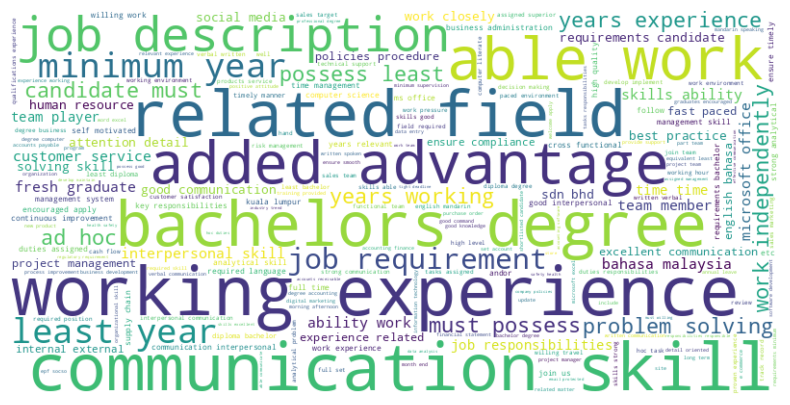

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all descriptions into a single string
text = ' '.join(data['descriptions'].fillna(''))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Extract years of working experience
We check which rows of data contains the word "year" or "experience", and abtract the number found.

In [30]:
import re

# Function to extract years of experience from descriptions
def extract_experience(text):
    # Check if either "year" (or its variants) or "experience" appears
    if re.search(r'\b(year|yr|years|yrs|experience)\b', text):
        # Extract the number of years if available
        experience_match = re.search(r'(\d+)\s*(?:year|yr|years|yrs)\s*(?:of)?\s*experience', text, re.IGNORECASE)
        if experience_match:
            return int(experience_match.group(1))  # Return number of years
        else:
            return 0  # If "experience" is mentioned but no number, return 0
    return 0

data['experience'] = data['descriptions'].apply(extract_experience)
data['experience'] = data['experience'].fillna(0)

print(data[['descriptions', 'experience']])


                                            descriptions  experience
0      join dynamic team key account executive oil ga...           3
1      job description wintoo looking pool dedicated ...           0
2      hiring sales executives industrial microbiolog...           0
3      job descriptions responsible expand business n...           0
4      responsibilities role responsible developing r...           0
...                                                  ...         ...
59301  management trainee - based kuala lumpur right ...           0
59302  primary roles create engaging social media cam...           0
59303  job summary design deliver google gamuda ai di...           3
59304  job description back join us embracing next ge...           0
59305  hiring trainer hardware network facility cyber...           3

[59264 rows x 2 columns]


### Extract education level required
We use several types of educations level key words and search in the text to see which are matched in text descriptions.

In [31]:
# Function to extract education levels from descriptions
def extract_education(text):
    educations = {
        'bachelor': ['bachelor', "bachelor's degree", 'degree'],
        'master': ['master', "master's degree"],
        'phd': ['phd', 'doctorate'],
        'diploma': ['diploma'],
        'spm': ['spm']
    }
    found_education = []
    for degree, keywords in educations.items():
        if any(keyword in text for keyword in keywords):
            found_education.append(degree)

    return ', '.join(found_education) if found_education else "not mentioned"

data['education'] = data['descriptions'].apply(extract_education)
data['education'] = data['education'].fillna('not mentioned')

print(data[['descriptions', 'education']])


                                            descriptions  \
0      join dynamic team key account executive oil ga...   
1      job description wintoo looking pool dedicated ...   
2      hiring sales executives industrial microbiolog...   
3      job descriptions responsible expand business n...   
4      responsibilities role responsible developing r...   
...                                                  ...   
59301  management trainee - based kuala lumpur right ...   
59302  primary roles create engaging social media cam...   
59303  job summary design deliver google gamuda ai di...   
59304  job description back join us embracing next ge...   
59305  hiring trainer hardware network facility cyber...   

                    education  
0                    bachelor  
1                         spm  
2                    bachelor  
3      bachelor, diploma, spm  
4      bachelor, diploma, spm  
...                       ...  
59301            diploma, spm  
59302       bachelor, d

### Check fresh graduate friendly companies
Some companies might welcome the fresh graduates to work in their companies. Hence, we look for the keywords "fresh graduate" in the text.

In [32]:
def is_fresh_graduate(text):
    keywords = ['fresh graduate']
    for keyword in keywords:
        if keyword in text:
            return True
    return False

data['fresh_graduate'] = data['descriptions'].apply(is_fresh_graduate)
data['fresh_graduate'] = data['fresh_graduate'].fillna(False)

print(data[['descriptions', 'fresh_graduate']])

                                            descriptions  fresh_graduate
0      join dynamic team key account executive oil ga...           False
1      job description wintoo looking pool dedicated ...            True
2      hiring sales executives industrial microbiolog...            True
3      job descriptions responsible expand business n...            True
4      responsibilities role responsible developing r...           False
...                                                  ...             ...
59301  management trainee - based kuala lumpur right ...           False
59302  primary roles create engaging social media cam...           False
59303  job summary design deliver google gamuda ai di...           False
59304  job description back join us embracing next ge...            True
59305  hiring trainer hardware network facility cyber...           False

[59264 rows x 2 columns]


### Extract language required
Different companies require employees to know different languages. Therefore, we identify the most commonly mentioned languages by searching for a list of common languages in the descriptions.



In [33]:
# Function to extract languages from descriptions
def extract_languages(text):
    languages = {
        'english': ['english', 'eng'],
        'malay': ['bahasa', "bahasa malaysia"],
        'chinese': ['chinese', 'bahasa cina','mandarin'],
        'cantonese': ['cantonese'],
        'japanese': ['japanese'],
        'korean': ['korean'],
        'french': ['french'],
        'german': ['german'],
        'spanish': ['spanish'],
        'italian': ['italian']
    }
    found_languages = []
    for language, keywords in languages.items():
        if any(keyword in text for keyword in keywords):
            found_languages.append(language)

    return ', '.join(found_languages) if found_languages else "not mentioned"

data['languages'] = data['descriptions'].apply(extract_languages)
data['languages'] = data['languages'].fillna('not mentioned')

print(data[['descriptions', 'languages']])


                                            descriptions  \
0      join dynamic team key account executive oil ga...   
1      job description wintoo looking pool dedicated ...   
2      hiring sales executives industrial microbiolog...   
3      job descriptions responsible expand business n...   
4      responsibilities role responsible developing r...   
...                                                  ...   
59301  management trainee - based kuala lumpur right ...   
59302  primary roles create engaging social media cam...   
59303  job summary design deliver google gamuda ai di...   
59304  job description back join us embracing next ge...   
59305  hiring trainer hardware network facility cyber...   

                     languages  
0               english, malay  
1                not mentioned  
2               english, malay  
3               english, malay  
4      english, malay, chinese  
...                        ...  
59301                  english  
59302          

### Word Clouds for Each Job Categories

In [34]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to get most common tokens for each category based on specific keywords in "descriptions"
def most_common_tokens_by_category_filtered(df, category_column, text_column):
    # Define a regular expression pattern to match any of the words: "skill", "skills", "requirement", or "requirements"
    pattern = r'\b(skill|skills|requirement|requirements)\b'

    # Filter the DataFrame to only include rows where the pattern appears in the "descriptions" column
    filtered_df = df[df[text_column].str.contains(pattern, case=False, na=False)]

    # Group the filtered data by the category column
    grouped = filtered_df.groupby(category_column)[text_column].apply(' '.join)  # Concatenate descriptions for each category

    # Create a dictionary to store the most common tokens for each category
    common_tokens_by_category = {}

    for category, text in grouped.items():
        # Tokenize the text for each category
        tokens = text.split()
        token_counts = Counter(tokens)

        # Get the 10 most common tokens for this category
        common_tokens_by_category[category] = token_counts.most_common(10)

    return common_tokens_by_category

result = most_common_tokens_by_category_filtered(data, 'category', 'descriptions')

categories = list(result.keys())
num_categories = len(categories)

for i in range(0, num_categories, 2):

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for j, ax in enumerate(axes):
        if i + j < num_categories:
            category = categories[i + j]
            common_tokens = result[category]

            word_frequencies = dict(common_tokens)

            wordcloud = WordCloud(
                width=600,
                height=300,
                background_color='white',
                contour_color='black',
                contour_width=2
            ).generate_from_frequencies(word_frequencies)

            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(f"Word Cloud for Category '{category}'")

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

### Extract Skills Required
Soft skills and techinical skills are required diferently by different companies. We will look into them by using the most common key words among the skills such as "patience", "leadership", etc. However, for technical skills, due to the knowledge limitations, we only detect for Information Technology / Computer Science field, which falls under Category "Information & Communication Technology".


In [35]:
soft_skills = [
    "teamwork", "communication", "problem-solving", "adaptability", "creativity",
    "time management", "critical thinking", "emotional intelligence", "leadership",
    "interpersonal skills", "conflict resolution", "collaboration", "active listening",
    "negotiation", "decision-making", "attention to detail", "flexibility", "work ethic",
    "resilience", "motivation", "positive", "open-mindedness", "patience",
    "stress", "multitasking", "accountability", "self-motivation",
    "customer service", "relationship building", "delegation", "presentation skills",
    "organizational skills", "self-confidence", "assertiveness",
    "learning agility", "interpersonal communication", "presentation skills",
    "empathy", "cultural sensitivity", "networking", "visionary thinking", "adaptability to change"
]


In [36]:
# Remove duplicates from the skills list
soft_skills = list(set(soft_skills))

In [37]:
# Function to check for all matched soft skills in the description
def matched_soft_skills(text):
    matched_skills = []
    for skill in soft_skills:
        if skill in text:
            matched_skills.append(skill)
    return ", ".join(matched_skills) if matched_skills else "not mentioned"

data['soft_skills'] = data['descriptions'].apply(matched_soft_skills)
data['soft_skills'] = data['soft_skills'].fillna('not mentioned')

print(data[['descriptions', 'soft_skills']])


                                            descriptions  \
0      join dynamic team key account executive oil ga...   
1      job description wintoo looking pool dedicated ...   
2      hiring sales executives industrial microbiolog...   
3      job descriptions responsible expand business n...   
4      responsibilities role responsible developing r...   
...                                                  ...   
59301  management trainee - based kuala lumpur right ...   
59302  primary roles create engaging social media cam...   
59303  job summary design deliver google gamuda ai di...   
59304  job description back join us embracing next ge...   
59305  hiring trainer hardware network facility cyber...   

                                      soft_skills  
0                                   communication  
1                                   not mentioned  
2                                   communication  
3      interpersonal communication, communication  
4               tim

## Drop unecessary columns

The "job_id" column serves as the index and does not provide meaningful information for analysis. Similarly, the "job_title" column mainly serves as a label to attract job seekers and offers limited value for modeling. The "company" is just the name of those companies, we would not analyze by companies hence we can drop it. Finally, since we have extracted all useful informations from the "location", "salary", and "descriptions" columns, these original columns can be safely removed.

In [38]:
data.drop(['job_id', 'job_title', 'company', 'location','salary','descriptions'], axis=1, inplace=True)

In [39]:
data.columns

Index(['category', 'subcategory', 'role', 'type', 'listingDate',
       'salary_missing', 'min_salary', 'max_salary', 'bonus', 'work_from_home',
       'hybrid', 'state', 'experience', 'education', 'fresh_graduate',
       'languages', 'soft_skills'],
      dtype='object')

In [40]:
data.isnull().sum()

,0
category,0
subcategory,0
role,0
type,0
listingDate,0
salary_missing,0
min_salary,0
max_salary,0
bonus,0
work_from_home,0


In [41]:
print(data.dtypes)

category           object
subcategory        object
role               object
type               object
listingDate        object
salary_missing       bool
min_salary        float64
max_salary        float64
bonus                bool
work_from_home       bool
hybrid               bool
state              object
experience          int64
education          object
fresh_graduate       bool
languages          object
soft_skills        object
dtype: object


# 3.0 Data Visualization

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### Job Category Distribution



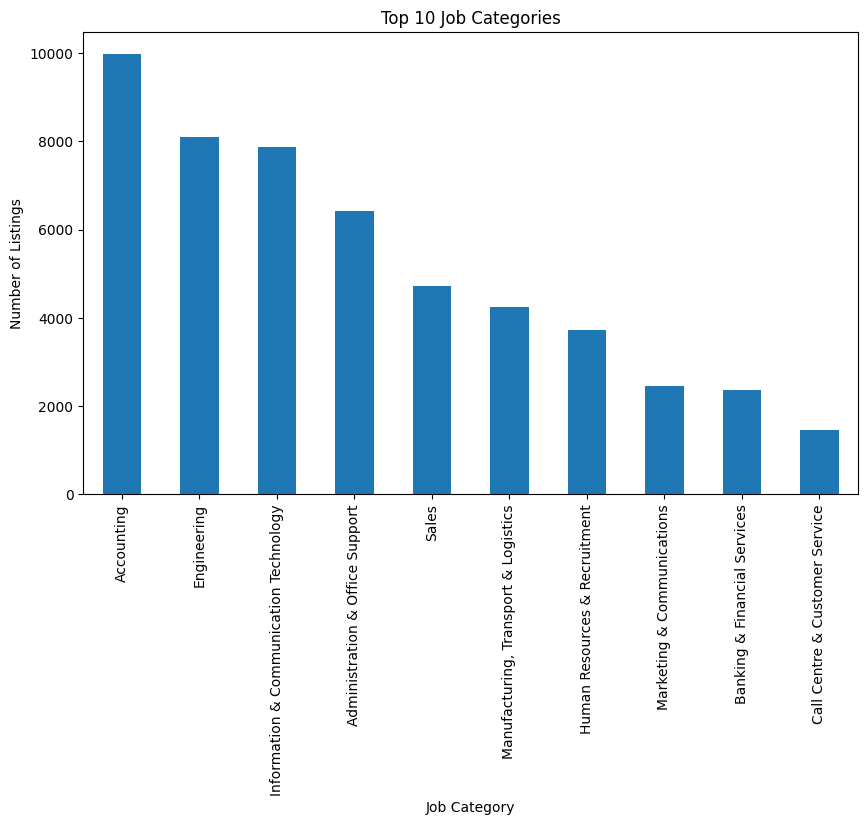

In [43]:
top_categories = data['category'].value_counts().head(10)
top_categories.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Job Categories')
plt.xlabel('Job Category')
plt.ylabel('Number of Listings')
plt.show()

Based on the bar plot:
1. The Accounting category has the highest number of job listings, followed by Engineering and Information & Communication Technology (ICT). This trend indicates a higher demand for professionals in these fields, suggesting a greater likelihood of finding job opportunities in these sectors.

2. Marketing & Communications, Banking & Financial Services, and Call Centre & Customer Service have the fewest job listings, indicating lower demand in these sectors and a reduced likelihood of finding job opportunities in these fields.

### Subcategories Distributions by Categories

<ipython-input-44-65b392ab0276>:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


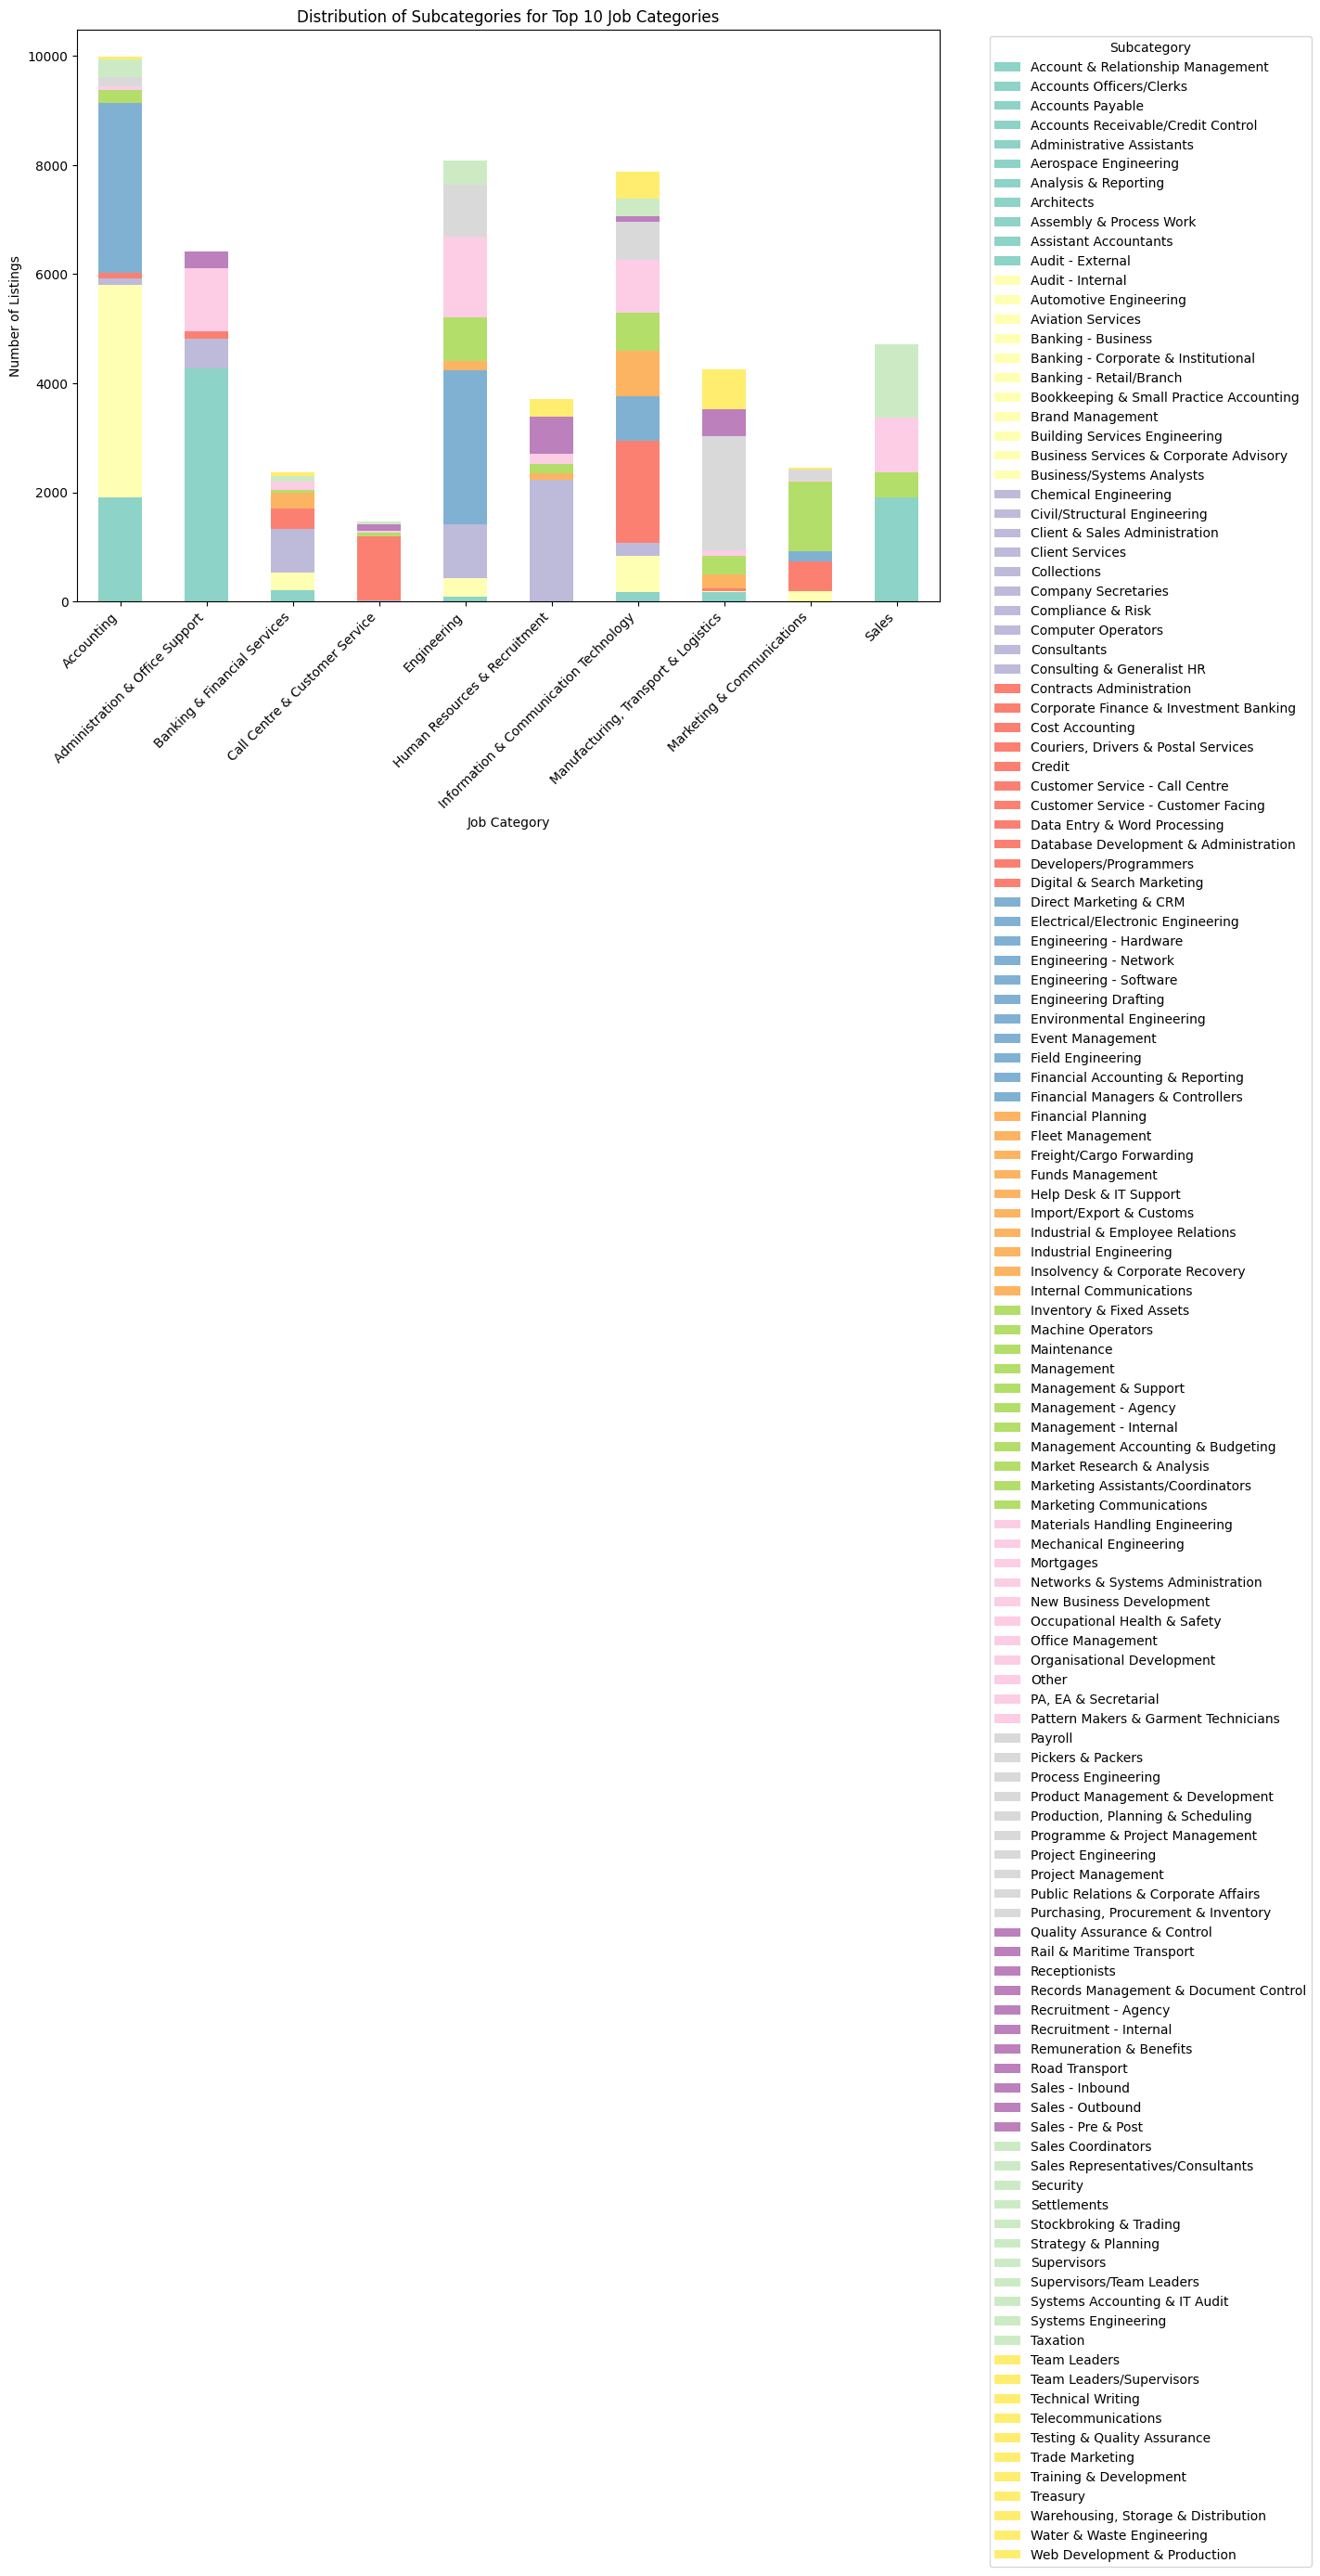

In [44]:
# Get the top 10 job categories
top_categories = data['category'].value_counts().head(10)

# Filter the data to include only the top 10 categories
top_categories_data = data[data['category'].isin(top_categories.index)]

# Create a pivot table to get the distribution of 'subcategory' for each 'category'
subcategory_distribution = top_categories_data.groupby('category')['subcategory'].value_counts().unstack(fill_value=0)

ax = subcategory_distribution.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set3')

plt.title('Distribution of Subcategories for Top 10 Job Categories')
plt.xlabel('Job Category')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



Based on the plot above:

1. High listing volumes Accounting suggest that these roles are in high demand across the job market.

2. The variety of subcategories within each job type indicates a diverse range of roles and opportunities, catering to individuals with different skill sets.

3. Subcategories in Information & Communication Technology (e.g., "Engineering - Software" and "Help Desk & IT Support") suggest a growing reliance on technology and a need for skilled professionals in digital roles.

4. Categories like "Sales" have broader, more general roles, whereas fields like "Engineering" and "Information & Communication Technology" require more specialized skills.

5. Companies likely prioritize customer-facing roles (Sales) and financial management roles (Accounting), reflecting their business-critical importance.

6. Job seekers might benefit from training in specialized areas like IT or Engineering, as these subcategories show consistent demand.

7. Industries related to Sales, IT, and Engineering may be expanding, while traditional support roles like "Administration" might be more stable or less prioritized.

### Top States for Jobs

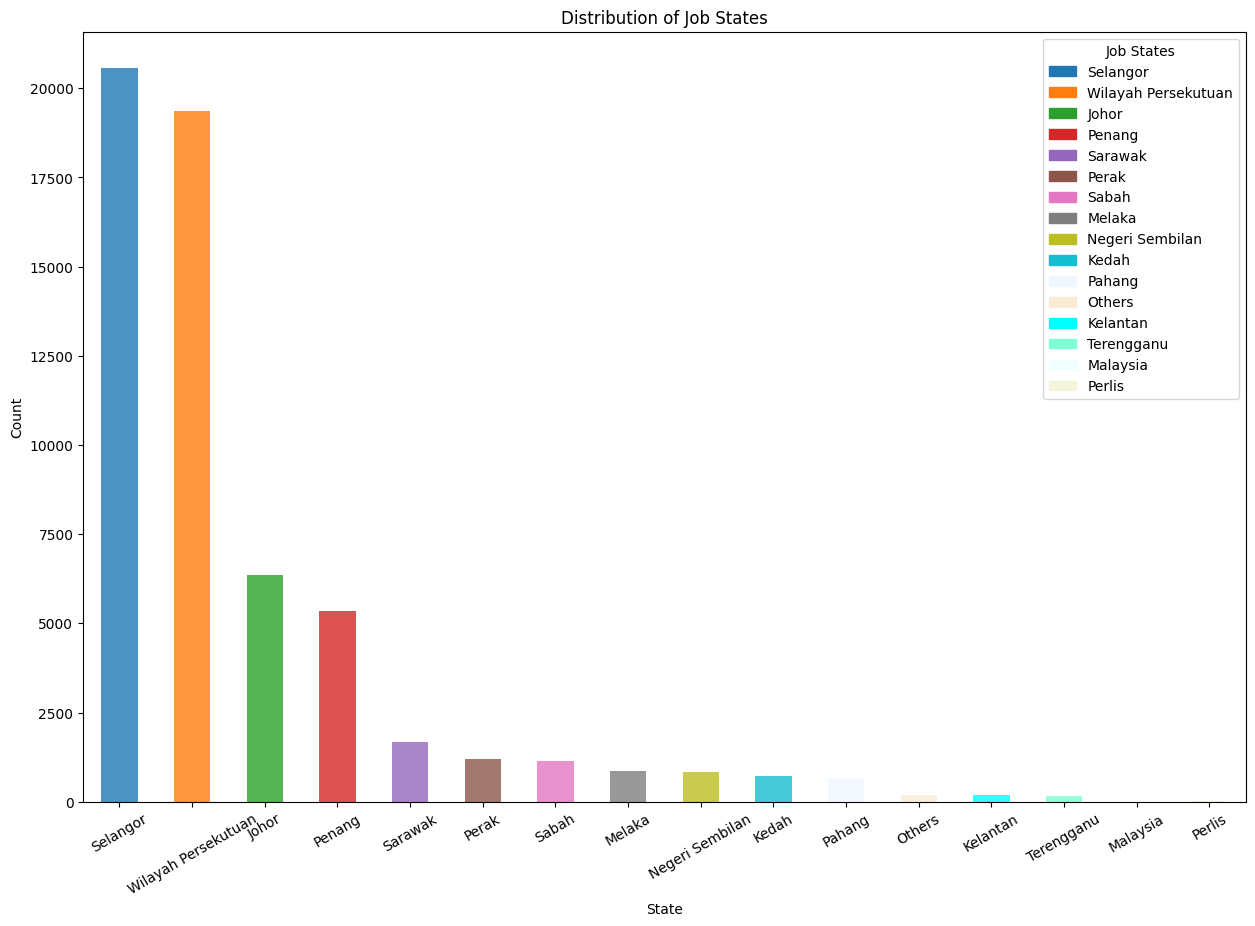

In [45]:
categories = data['state'].value_counts().index
category_colors = list(mcolors.TABLEAU_COLORS.values())

if len(categories) > len(category_colors):
    css4_colors = list(mcolors.CSS4_COLORS.values())
    category_colors += css4_colors

color_dict = {category: category_colors[i] for i, category in enumerate(categories)}

plt.figure(figsize=(15, 10))
category_counts = data['state'].value_counts()

category_counts.plot(kind='bar', color=[color_dict[category] for category in category_counts.index], alpha=0.8)

handles = [plt.Rectangle((0,0), 1, 1, color=color_dict[category]) for category in category_counts.index]
labels = category_counts.index
plt.legend(handles, labels, title="Job States")

plt.title('Distribution of Job States')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()


The chart highlights the number of job postings in each Malaysian state.

States like Selangor and Wilayah Persekutuan dominate in job postings, while states such as Perlis, Terengganu, and Kelantan show minimal opportunities.


1. Selangor and Wilayah Persekutuan dominate the job market, each with over 20,000 job listings, offering the most employment opportunities.

2. Johor and Penang follow closely, with a significant number of job postings.

3. Other states, such as Sarawak, Perak, Sabah, Melaka, Negeri Sembilan, Kedah, and Pahang, have relatively fewer job opportunities, with job listings in these states not even reaching half of those in Johor or Penang.

4. Perlis contributes the least to the job market, making it highly unlikely to find job opportunities in the state.

### Job Categories Based On State

<Figure size 3000x1400 with 0 Axes>

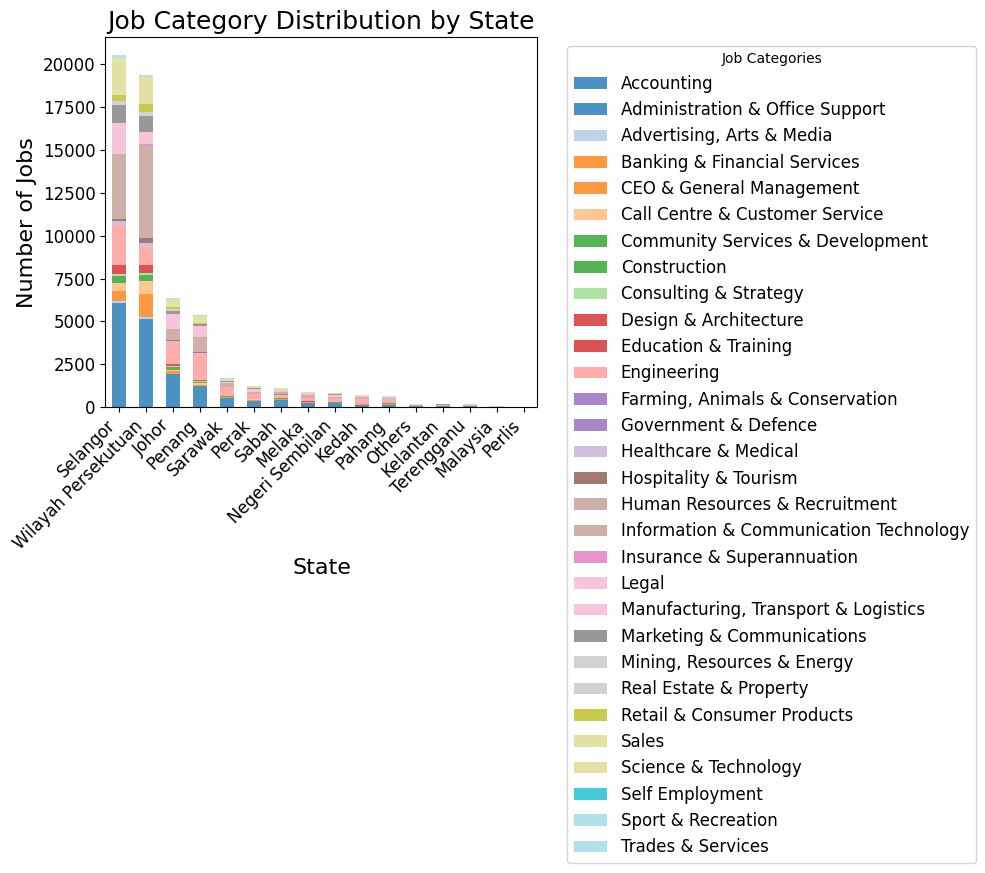

In [46]:
# Count the total number of job listings per state
state_totals = data['state'].value_counts()

# Sort the states by the total number of job listings
sorted_states = state_totals.sort_values(ascending=False).index

# Group by state and category
state_category_counts = data.groupby(['state', 'category']).size().unstack(fill_value=0)

state_category_counts = state_category_counts.loc[sorted_states]

plt.figure(figsize=(30, 14))
state_category_counts.plot(kind='bar', stacked=True, colormap='tab20', alpha=0.8)

plt.title('Job Category Distribution by State', fontsize=18)
plt.xlabel('State', fontsize=16)
plt.ylabel('Number of Jobs', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-ticks for readability
plt.yticks(fontsize=12)

plt.legend(title="Job Categories", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.subplots_adjust(right=0.8)

plt.show()


Based on the plot above:
1. We can observe that the top 3 most popular job categories in Selangor and Wilayah Persekutuan are Accounting, Information & Communication Technology, and Sales. This trend aligns with the overall job market, as the top 10 job categories across Malaysia mirror the most sought-after categories in these states, which also offer the highest number of job opportunities. This correlation highlights that the most popular job categories are concentrated in regions with significant employment prospects.

2. We also oberve that Accounting and Engineering are very common among the majority states.


Based on the plot above:

We can observe that the top 3 most popular job categories in Selangor and Wilayah Persekutuan are Accounting, Information & Communication Technology, and Sales. This trend aligns with the overall job market, as the top 10 job categories across Malaysia mirror the most sought-after categories in these states, which also offer the highest number of job opportunities. This correlation highlights that the most popular job categories are concentrated in regions with significant employment prospects.

We also observe that Accounting and Engineering are very common among the majority states.

Insights:

- Selangor has the highest number of job listings across all categories, followed by Wilayah Persekutuan (Kuala Lumpur) and Johor. These regions are economic hubs in Malaysia, known for their developed infrastructure and concentration of industries. Perlis, Terengganu, Kelantan, and Pahang show significantly fewer job opportunities, indicating that these states might have less industrial and economic activity compared to others.

- Accounting dominates in most states, reflecting the universal demand for finance-related roles. Other significant categories include Engineering, Information & Communication Technology (ICT), and Sales, which are consistently present in higher numbers, especially in industrialized states like Selangor and Johor.

### Popular Roles

In [47]:
data['role'] = data['role'].str.lower().str.strip()
data['role'] = data['role'].replace({'accounts-executive': 'account-executive'})

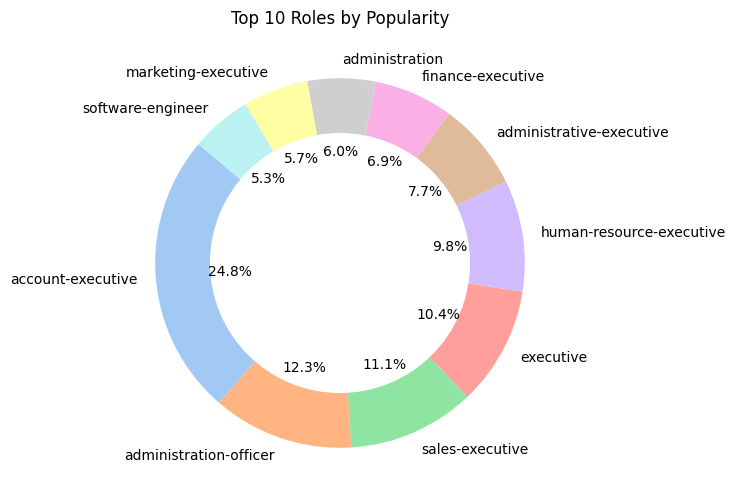

In [48]:
role_counts = data['role'].value_counts().head(10)

plt.figure(figsize=(10, 6))
role_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
circle = plt.Circle((0, 0), 0.70, color='white')
plt.gca().add_artist(circle)  # Add a white circle for the donut effect
plt.title('Top 10 Roles by Popularity')
plt.ylabel('')
plt.show()

The chart visualizes the most common job roles and their percentage share among the top 10 roles.

Roles like account-executive and administration-officer dominate, while roles like software-engineer and marketing-executive are less frequent.

1. The "account-executive" role is the most popular position, indicating a very strong demand for customer management skills.
2. The "administrative-officer" role accounted for 12.3%, and "sales executives" accounted for 11.1%, highlighting the importance of operational and sales positions.
3. In contrast, the positions of "software-engineering" and "marketing-executive" are less popular, which may indicate a skills gap or heavy workload in these positions.
4. Training programs and job fairs can emphasize less popular roles to balance the skill.

### Job Types Distributions

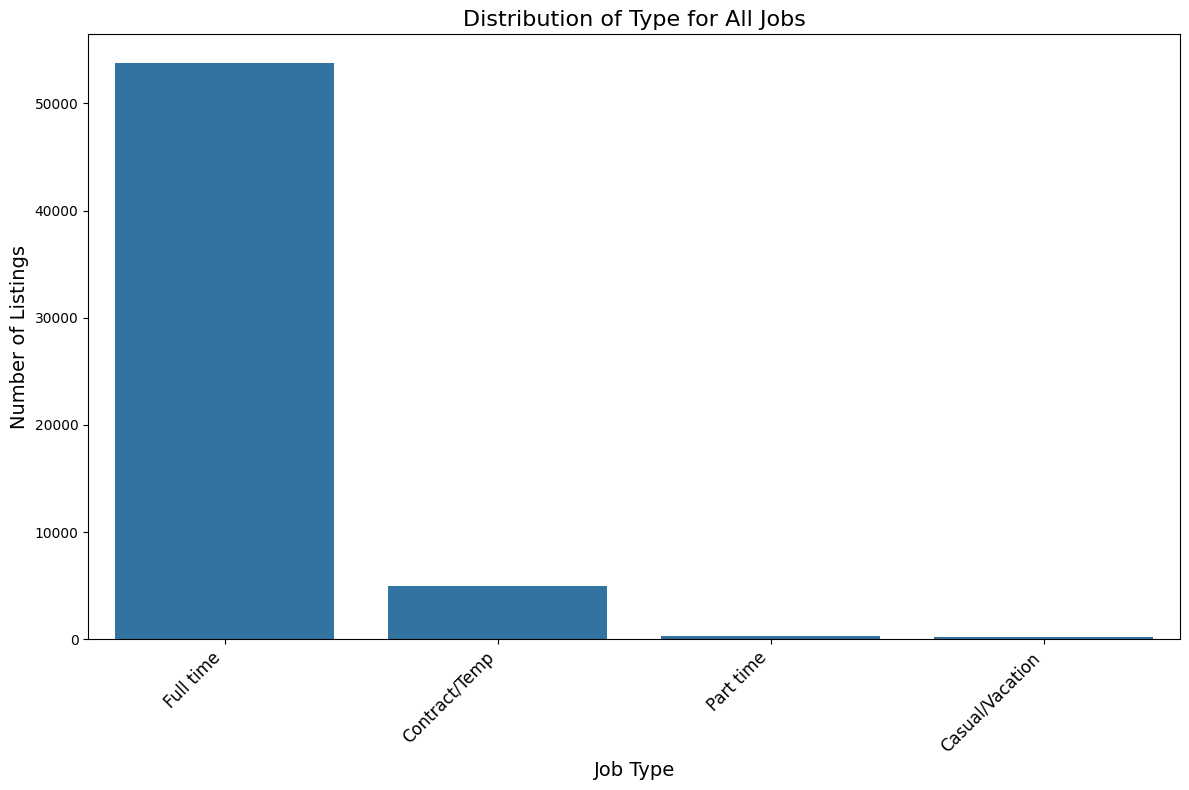

In [49]:
# Get the distribution of job types
type_distribution = data['type'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=type_distribution.index, y=type_distribution.values)

plt.title('Distribution of Type for All Jobs', fontsize=16)
plt.xlabel('Job Type', fontsize=14)
plt.ylabel('Number of Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

plt.show()


Based on the bar plot:

1. The majority of job listings are for Full-time positions, significantly outpacing all other job types. This reflects the preference of employers for employees who can commit to a stable, long-term arrangement.

2. Contract/Temp jobs form the second-largest category but are considerably smaller compared to full-time roles. Part-time and Casual/Vacation job listings are minimal, indicating limited opportunities for those seeking flexible or temporary work arrangements.

3. Employers may prefer full-time roles due to the stability and continuity they offer for their operations, while fewer opportunities for part-time or casual jobs may point to industry-specific needs.

4. The dominance of full-time roles suggests a job market geared towards traditional employment, where employees are expected to dedicate their time fully to the organization. Sectors requiring consistent availability and commitment, like Accounting, IT, and Sales, might contribute to the high share of full-time jobs.

5. The relatively small proportion of Part-time and Casual/Vacation jobs may indicate a gap for individuals seeking work-life balance, such as students, parents, or those looking for supplementary income.

6. Industries reliant on seasonal demand (e.g., Hospitality, Retail) or project-based work (e.g., Construction, Consulting) might contribute more to Contract/Temp jobs, but these roles remain a smaller share of the market overall.

### Job Types Distributions by Categories

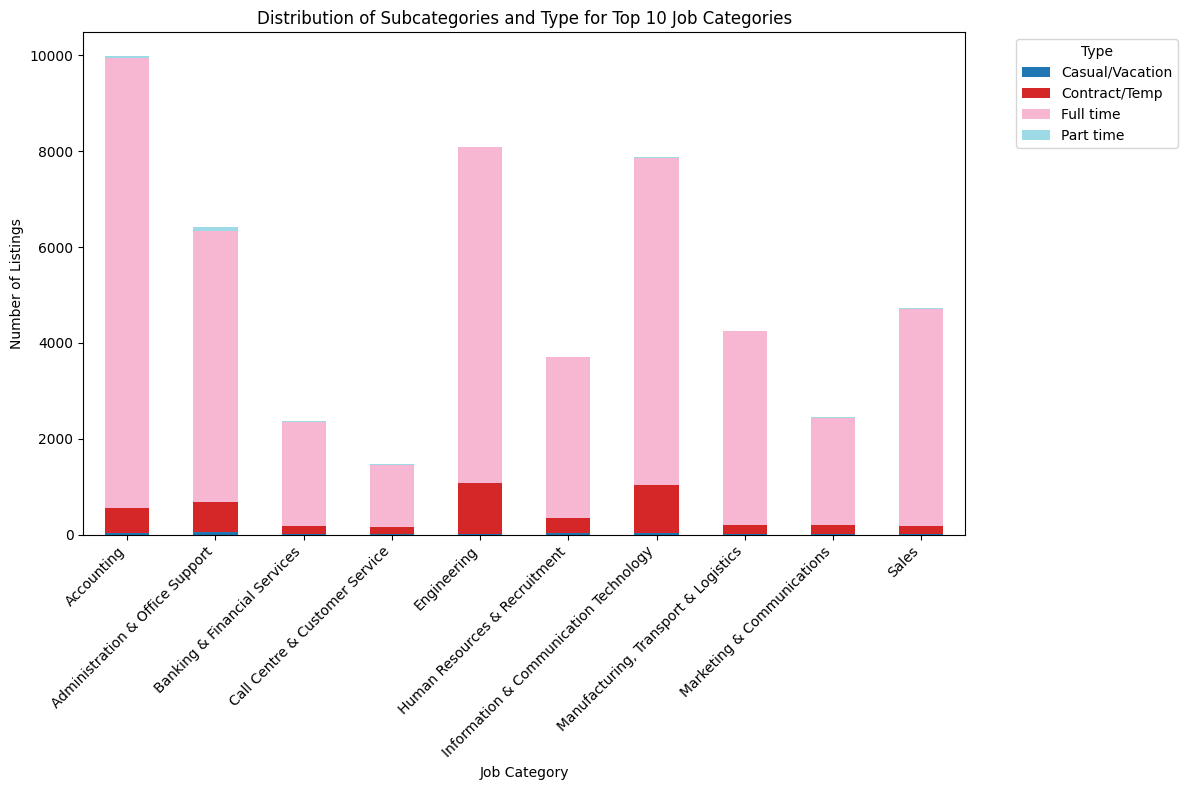

In [50]:
# Get the top 10 job categories
top_categories = data['category'].value_counts().head(10)

# Filter the data to include only the top 10 categories
top_categories_data = data[data['category'].isin(top_categories.index)]

# Create a pivot table to get the distribution of 'type' for each 'category'
subcategory_type_distribution = top_categories_data.groupby(['category', 'type']).size().unstack(fill_value=0)

ax = subcategory_type_distribution.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')

plt.title('Distribution of Subcategories and Type for Top 10 Job Categories')
plt.xlabel('Job Category')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()


The chart shows the distribution of subcategories and job types for the top 10 job categories. The job categories are ranked by the total number of listings, with Accounting & Engineering having the most listings. Each job category is broken down into 4 job types: Casual/Vacation, Contract/Temp, Full time, and Part time. The job type with the highest representation across most categories is Full time. Some job categories like Engineering and Information & Communication Technology have a relatively higher proportion of Contract/Temp roles. Sales and Marketing & Communications have a notable presence of Part time roles.

We can observe that:

- The job market appears to be dominated by full-time permanent roles.
- However, there is also significant demand for contract, temporary, and part-time work, particularly in technical, admin, and sales.
- The data suggests areas like engineering, manufacturing, and transportation may have more project-based or short-term hiring requirements compared to roles in accounting, banking, or marketing.

Overall, the chart provides a high-level view of the breakdown of job opportunities by category and employment type, which could be useful for job seekers to understand the landscape and identify potential areas of focus.

### Salary Trends by Job Role

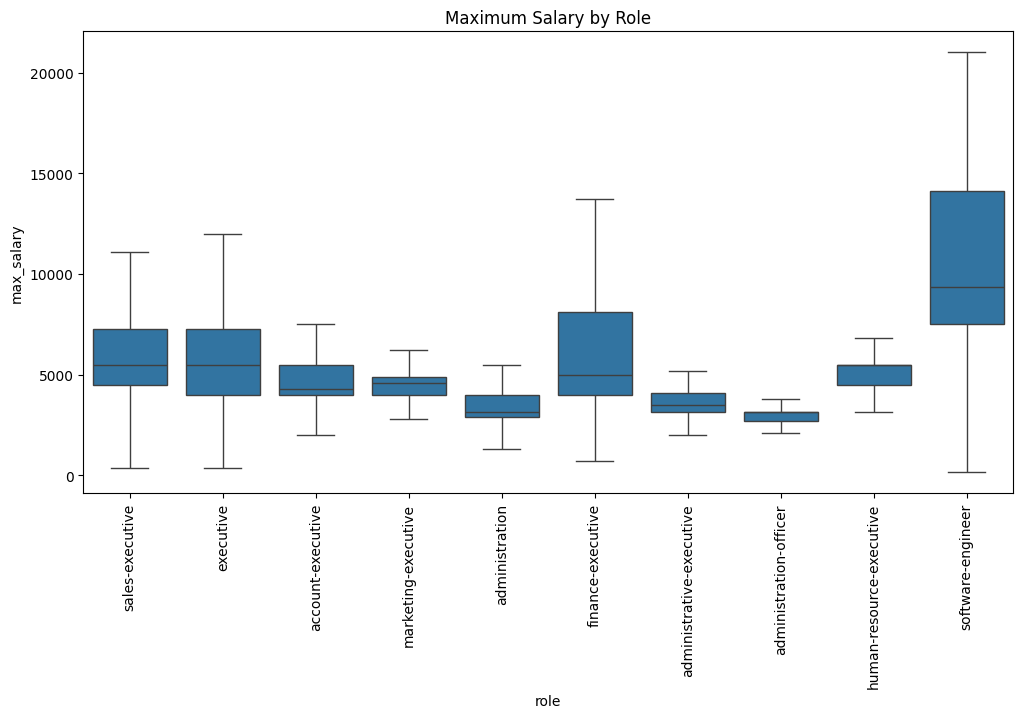

In [51]:
top_roles = data['role'].value_counts().head(10)
filtered_roles = data[data['role'].isin(top_roles.index)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='role', y='max_salary', data=filtered_roles, showfliers=False)
plt.title('Maximum Salary by Role')
plt.xticks(rotation=90)
plt.show()

The box plot compares the maximum salary ranges for different roles.

Roles like software-engineering show the widest range and highest salaries, while administrative-officer roles have a narrower and lower salary range.

1. Among all positions, "software-engineer" has the largest salary range and a significantly wider distribution, which indicates that this position has greater salary potential compared to other positions.

2. Positions such as "sales-executive", "executive" and "finance-executive" have relatively high median salaries, with the salary range for "finance-executive" being wider, indicating that salary levels vary depending on experience or organization.

3. Median salaries for roles such as "administrative-officer", "human-resource-executive" and "administrative-executive", tend to be lower and more narrow, indicating more stable and generally lower salary levels.

4. Companies may need to adjust the salary of low-paid positions to retain talent in key support functions, while ensuring fairness in high-paying and popular positions.

### Monthly Trends

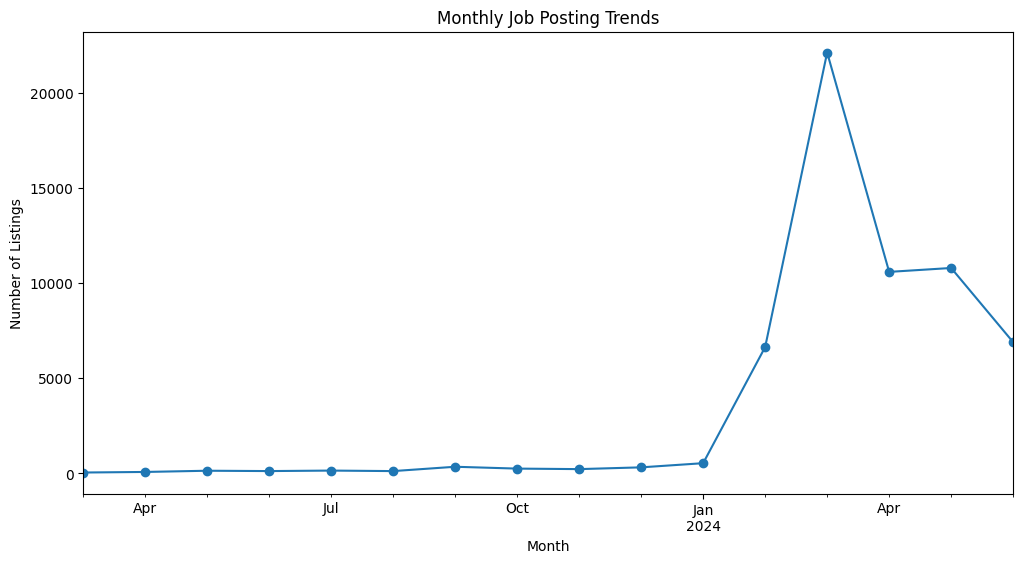

In [52]:
data['listingDate'] = pd.to_datetime(data['listingDate'])
monthly_trends = data['listingDate'].dt.to_period('M').value_counts().sort_index()

monthly_trends.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Monthly Job Posting Trends')
plt.xlabel('Month')
plt.ylabel('Number of Listings')
plt.show()

1. Job postings remained relatively stable at low levels throughout most of 2023.
2. A sharp increase is observed starting in late 2023, peaking in early 2024.
3. Post-peak, there’s a notable drop, but postings remain higher than previous months in 2023.

### Group salary trends by year and month

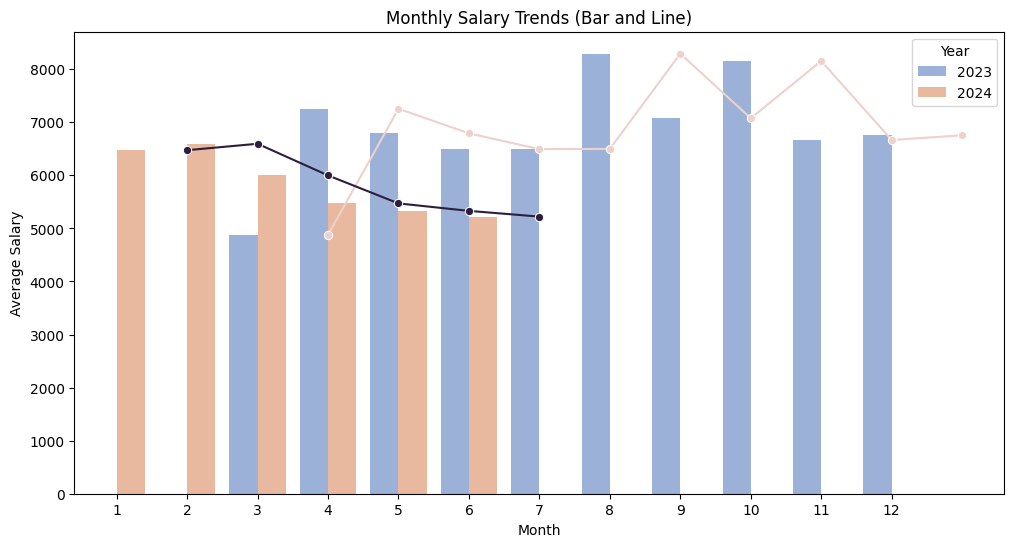

In [53]:
data['year'] = data['listingDate'].dt.year
data['month'] = data['listingDate'].dt.month
data['avg_salary'] = (data['min_salary'] + data['max_salary']) / 2

salary_trends = data.groupby(['year', 'month'])['avg_salary'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='avg_salary', hue='year', data=salary_trends, palette='muted', alpha=0.6)
sns.lineplot(x='month', y='avg_salary', hue='year', data=salary_trends, marker='o', legend=False, color='black')

plt.title('Monthly Salary Trends (Bar and Line)')
plt.xlabel('Month')
plt.ylabel('Average Salary')
plt.legend(title='Year')
plt.show()

1. The average salary level in 2023 is relatively stable throughout the year, with slight differences between months.
2. The highest average salary in 2023 is expected in the middle of the year, especially in August and October
3. The average salaries in 2024 show higher fluctuations than 2023.
4. April 2024 has a noticeable dip compared to prior months.
5. The highest average salaries for 2024 occur in February, followed by a gradual but slight decrease.

**Overall Insights:**
1. **State employment market trends:** Selangor and the Wilayah Persekutuan dominate, indicating that these areas are economic centers that provide the most employment opportunities. Businesses and professionals targeting the Malaysian job market should focus on these areas.

2. **Montly hiring trends:** A spike in early 2024 may indicate a seasonal hiring trend, possibly related to fiscal year planning or project starts. Normalization after the peak still indicates higher demand than in 2023, signaling a recovering or growing job market.

3. **Montly Salary Trends:** Despite job posting trends, which indicates that there may be economic adjustments, industry-specific transformations, or imbalances in supply and demand.

In months when performance is declining, employers may need to re-evaluate pay distribution to attract talent.

### Working Experience Required

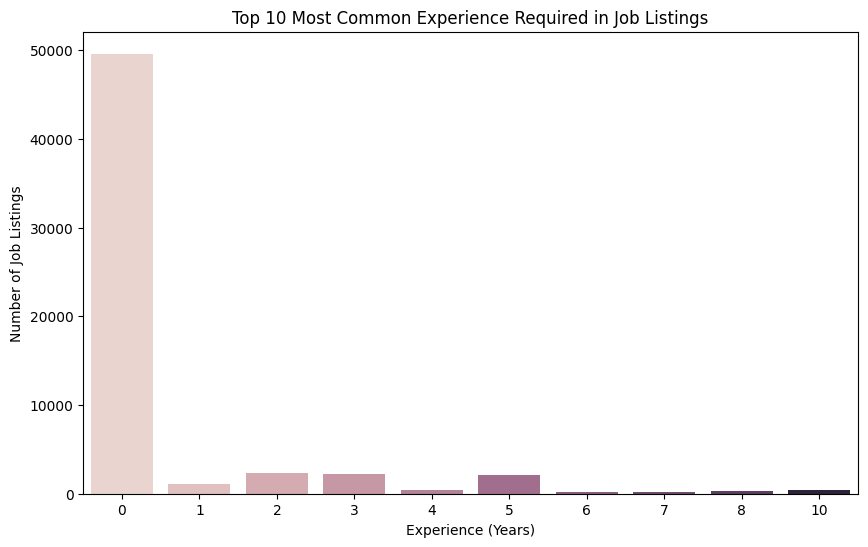

In [54]:
data['experience'] = pd.to_numeric(data['experience'], errors='coerce')  # Convert to numeric, set errors to NaN

# Get the top 10 most common experience values
top_experience = data['experience'].value_counts().nlargest(10)

# Plot the distribution for the top 10 experience values
plt.figure(figsize=(10, 6))
sns.barplot(x=top_experience.index, y=top_experience.values, hue=top_experience.index, dodge=False, legend=False)
plt.title('Top 10 Most Common Experience Required in Job Listings')
plt.xlabel('Experience (Years)')
plt.ylabel('Number of Job Listings')
plt.show()


The graph shows the top 10 most common experience levels required in job listings.

Based on the bar plot, we can see that:

1. The experience level with the highest demand is 0 years, indicating a large number of entry-level or junior roles available.

2. There is a significant drop-off in demand for roles requiring 1 year of experience compared to 0 years.

3. Roles requiring 2-3 years of experience have the next highest demand after 0 years.

4. The demand then steadily declines as the experience requirement increases, with the lowest demand for roles requiring 10 years of experience.

- This suggests there is greater availability of entry-level and mid-level roles compared to senior-level positions in the job market.
- Employers appear to be seeking a mix of experienced and less experienced candidates, with the greatest need for workers with 0-3 years of relevant experience.

The data could be useful for job seekers to understand the typical experience levels in-demand and tailor their applications accordingly.

### Education Level Required

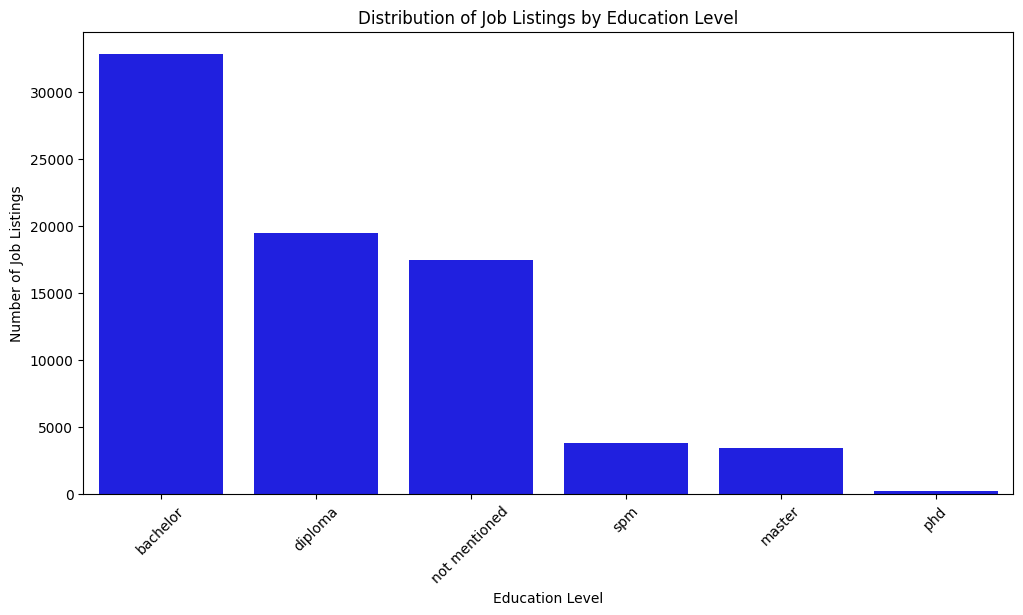

In [55]:
# Flatten the education list in each row
all_educations = data['education'].apply(lambda x: [edu.strip().lower() for edu in x.split(',')]).explode()

# Count the occurrences of each education type
education_counts = all_educations.value_counts()

# Plot the distribution of job listings by education level
plt.figure(figsize=(12, 6))
sns.barplot(x=education_counts.index, y=education_counts.values, color='b')
plt.title('Distribution of Job Listings by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Number of Job Listings')
plt.xticks(rotation=45)
plt.show()



The chart shows the distribution of job listings by education level required.

Based on the bar plot, we can observe that:

1. The education level with the highest number of listings is Bachelor's degree, with over 25,000 listings.

2. Diploma has the next highest number of listings, around 20,000.

3. While "Not mentioned" has around 15,000 listings, indicating many job postings do not specify an education requirement.

4. Master and spm have the lowest numbers, each under 5,000 listings. This suggests employers are primarily seeking candidates with bachelor's degrees or diplomas for the roles advertised.

The data could be useful for job seekers to understand the typical education levels in demand and align their qualifications accordingly.

### Fresh Graduate-Friendly Distribution

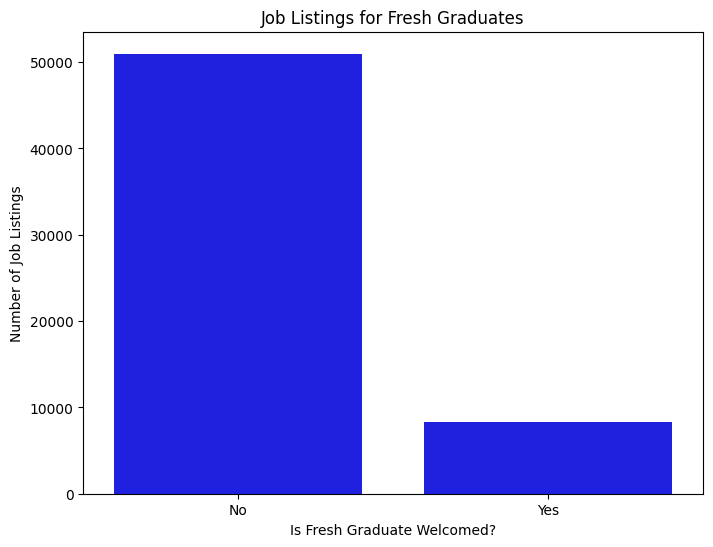

In [56]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='fresh_graduate', color='b')
plt.title('Job Listings for Fresh Graduates')
plt.xlabel('Is Fresh Graduate Welcomed?')
plt.ylabel('Number of Job Listings')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


The chart shows job listings for fresh graduates, with two categories: "No" and "Yes" indicating whether the listing is welcoming fresh graduates. The number of job listings that do not welcome fresh graduates is significantly higher, over 50,000 listings. The number of listings that do welcome fresh graduates is around 10,000.

1. The job market appears to have a greater demand for experienced candidates rather than recent graduates.

2. However, there is still a sizable number of opportunities, around 10,000 listings, that are open to fresh graduates.

3. Employers may be seeking more experienced talent for certain roles, while also providing entry-level opportunities for recent graduates.

This data could be valuable for new graduates to understand the job landscape and identify the types of roles that are more open to hiring them directly out of school.

### Languages Required

<ipython-input-57-7a00e7c05c37>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.index, y=language_counts.values, palette=sns.color_palette('viridis', len(language_counts)))


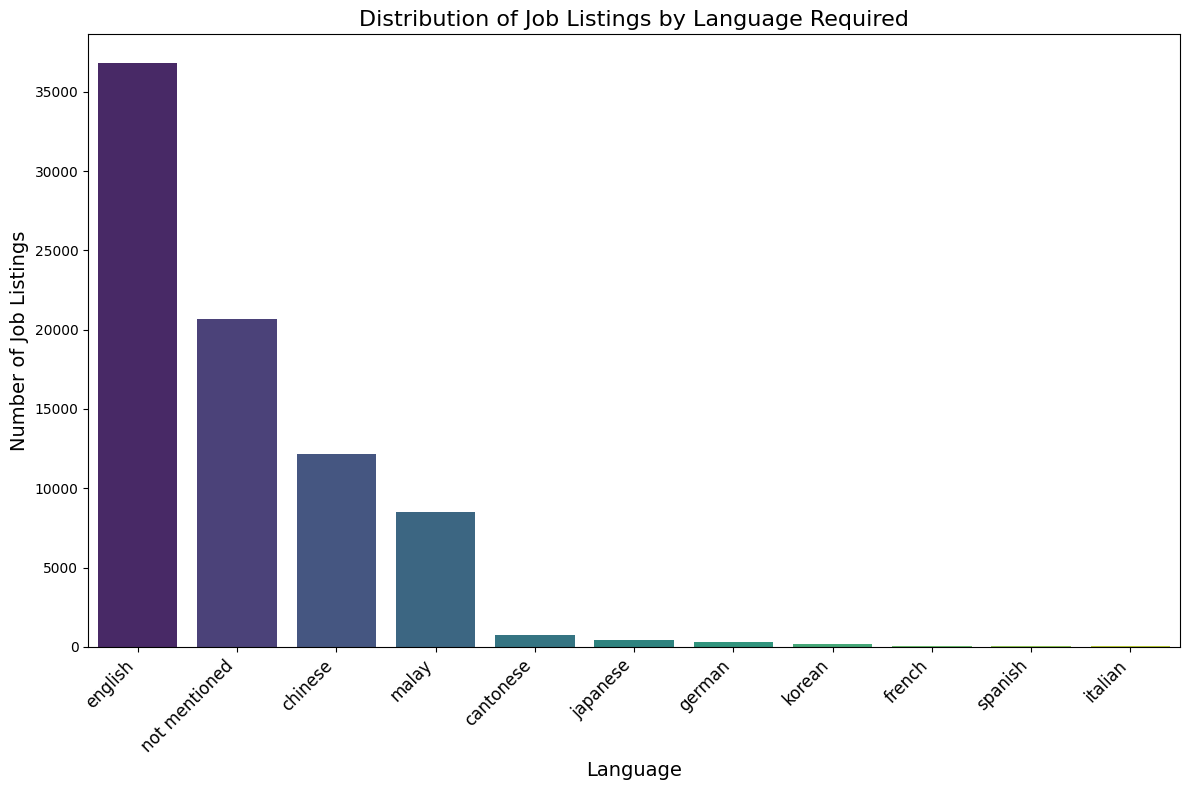

In [57]:
# Split the 'languages' column by commas, flatten the list, and count occurrences of each language
all_languages = data['languages'].apply(lambda x: [lang.strip() for lang in x.split(',')]).explode()

# Count the occurrences of each language
language_counts = all_languages.value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=language_counts.index, y=language_counts.values, palette=sns.color_palette('viridis', len(language_counts)))

plt.title('Distribution of Job Listings by Language Required', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Number of Job Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

plt.tight_layout()
plt.show()




The chart shows the distribution of job listings by the language required.

1. English has the highest number of listings, over 35,000. This indicate that English appears to be the predominant language required for the available job opportunities.

2. "Not mentioned" has the second highest number, around 20,000, indicating many listings do not specify a language requirement.

3. Chinese and Malay have the next highest numbers, each around 10,000 listings.

4. Other languages like Japanese, German, Korean, French, Spanish, and Italian have significantly fewer listings, all under 5,000.

The data indicates a need for multilingual talent, particularly in Chinese and Malay, in addition to English. Roles requiring niche languages like Japanese, German, Korean, French, Spanish, and Italian appear to be less common in the current job market. This information could be useful for job seekers to understand the language skills that are most in-demand and tailor their applications accordingly.

### 10 Common Soft Skills Required

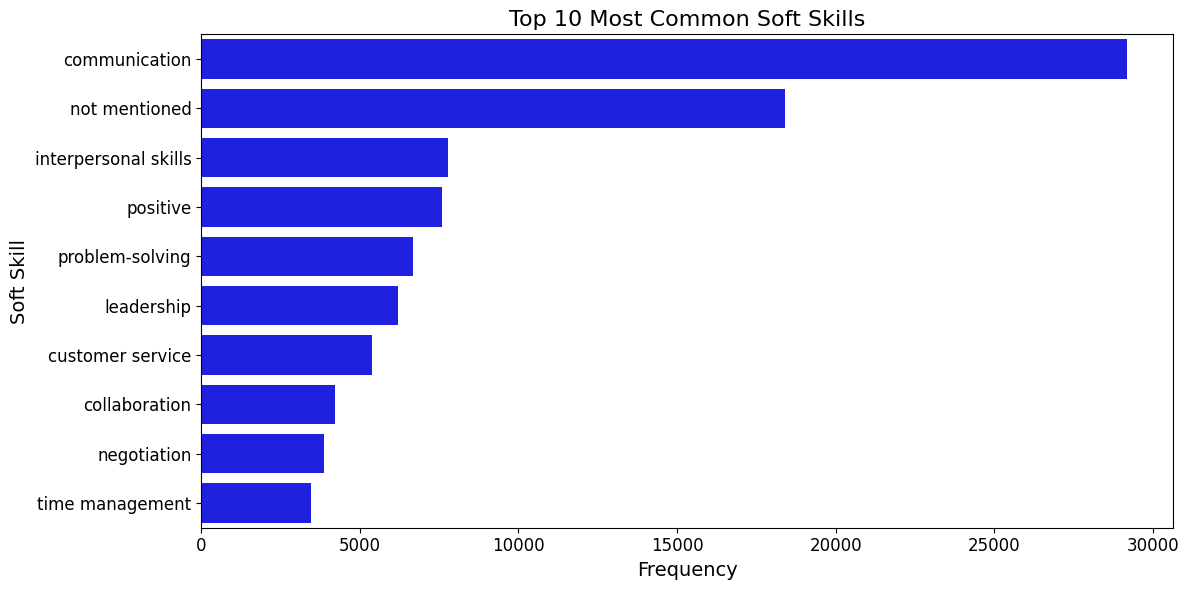

In [58]:
soft_skills_list = data['soft_skills'].apply(
    lambda x: x if isinstance(x, list) else [skill.strip() for skill in x.split(',')]
)

# Flatten the list of soft skills
flat_skills = [skill for sublist in soft_skills_list for skill in sublist]

# Count the occurrences of each soft skill
skills_counter = Counter(flat_skills)

# Get the top 10 most common soft skills
top_skills = skills_counter.most_common(10)
skills_df = pd.DataFrame(top_skills, columns=['Soft Skill', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Soft Skill', data=skills_df, color='b')  # Use a single color to avoid warnings
plt.title('Top 10 Most Common Soft Skills', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Soft Skill', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()




The chart shows the top 10 most commonly required soft skills in job listings.

1. Communication skills have the highest frequency, indicating they are the most in-demand soft skill.

2. "Not mentioned" is the second most common, suggesting many job postings do not explicitly list required soft skills. Some employers may not be explicitly listing all the desired soft skills in their job postings.

3. Interpersonal skills, positive attitude, and problem-solving also have high frequencies, ranking 3rd, 4th, and 5th respectively.

4. Leadership, customer service, collaboration, negotiation, and time management are the other top soft skills in demand.

5. Beyond communication, employers value interpersonal abilities, a positive mindset, and problem-solving skills. Leadership, customer service, collaboration, negotiation, and time management are also important soft skills that can differentiate candidates.

This information can help job seekers identify and highlight the key soft skills that are highly valued in the current job market.

### Soft Skills Required by Job Category

<Figure size 1500x1000 with 0 Axes>

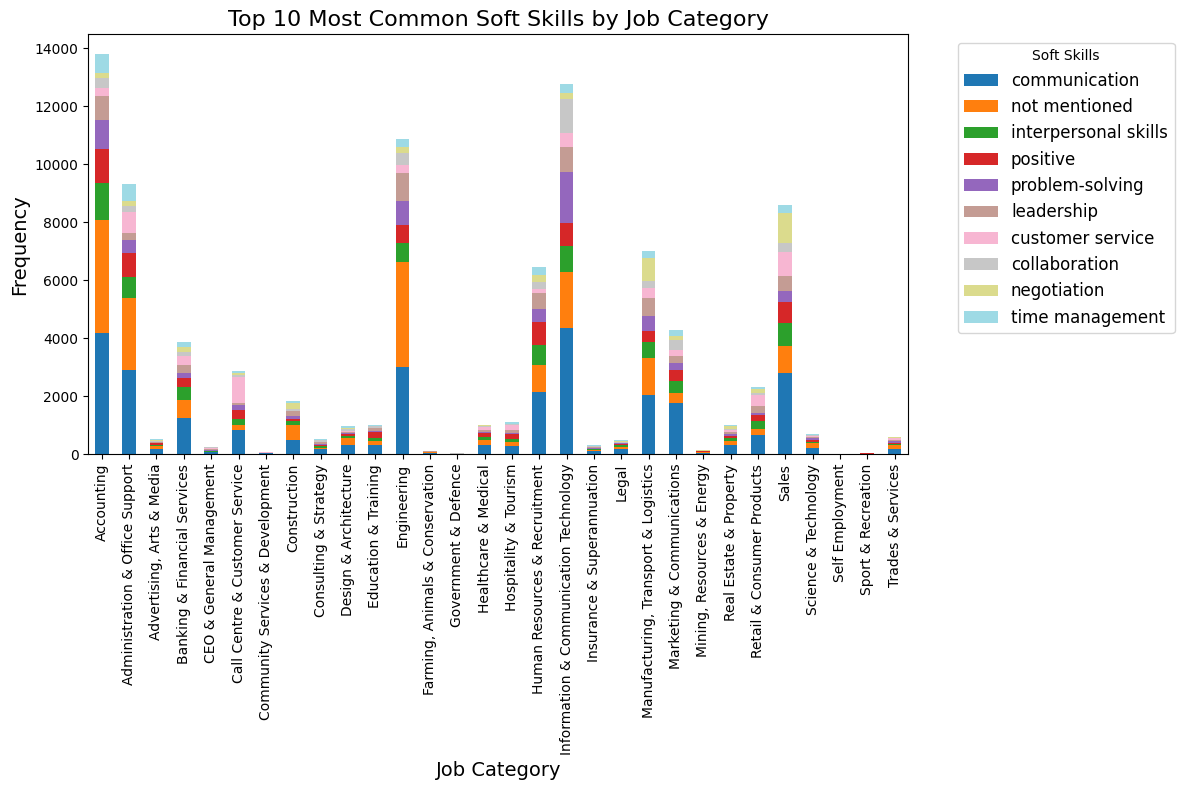

In [59]:
# Process the soft skills to flatten and count occurrences
soft_skills_list = data['soft_skills'].apply(
    lambda x: x if isinstance(x, list) else [skill.strip() for skill in x.split(',')]
)

# Flatten the list of soft skills
flat_skills = [skill for sublist in soft_skills_list for skill in sublist]

# Count the occurrences of each soft skill
skills_counter = Counter(flat_skills)

# Get the top 10 most common soft skills
top_skills = skills_counter.most_common(10)
top_skills_list = [skill for skill, _ in top_skills]

#Filter the soft skills by category and get the top skills
def process_soft_skills_for_category(group):
    soft_skills_list = group.apply(
        lambda x: x if isinstance(x, list) else [skill.strip() for skill in x.split(',')]
    )
    flat_skills = [skill for sublist in soft_skills_list for skill in sublist]
    return flat_skills

# Group by 'category' and process the 'soft_skills' for each job category
category_soft_skills = data.groupby('category')['soft_skills'].apply(process_soft_skills_for_category)

#Filter only the top 10 skills for each category
category_filtered_skills = category_soft_skills.apply(
    lambda skills: [skill for skill in skills if skill in top_skills_list]
)

# Count occurrences of each top skill within each category
filtered_skills_counter = category_filtered_skills.apply(lambda skills: Counter(skills))

# Create a DataFrame where each row corresponds to a job category and each column to a soft skill
soft_skills_expanded = filtered_skills_counter.apply(pd.Series).fillna(0)


plt.figure(figsize=(15, 10))
soft_skills_expanded[top_skills_list].plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')

plt.title('Top 10 Most Common Soft Skills by Job Category', fontsize=16)
plt.ylabel('Frequency', fontsize=14)  # y-axis represents the frequency of soft skills
plt.xlabel('Job Category', fontsize=14)  # x-axis represents the job categories
plt.legend(title='Soft Skills', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


The chart shows the top 10 most common soft skills required across different job categories.

1. Communication skills have the highest frequency across most job categories. This indicated effective communication is the most critical soft skill sought after by employers across a wide range of job roles.

2. "Not mentioned" is also common, indicating many job postings do not explicitly list required soft skills, leaving candidates to infer or highlight relevant abilities on their own.

3. Interpersonal skills, positive attitude, and problem-solving are other frequently demanded soft skills.

4. While communication skills are generally valued, the importance of other soft skills depends on the specific job category. For example, leadership and problem-solving skills also stand out in job categories such as accounting, ICT and engineering.

This data can help job seekers identify and emphasize the soft skills that are most in-demand for the types of roles they are interested in.

### Salary Range by Role

<Figure size 1200x600 with 0 Axes>

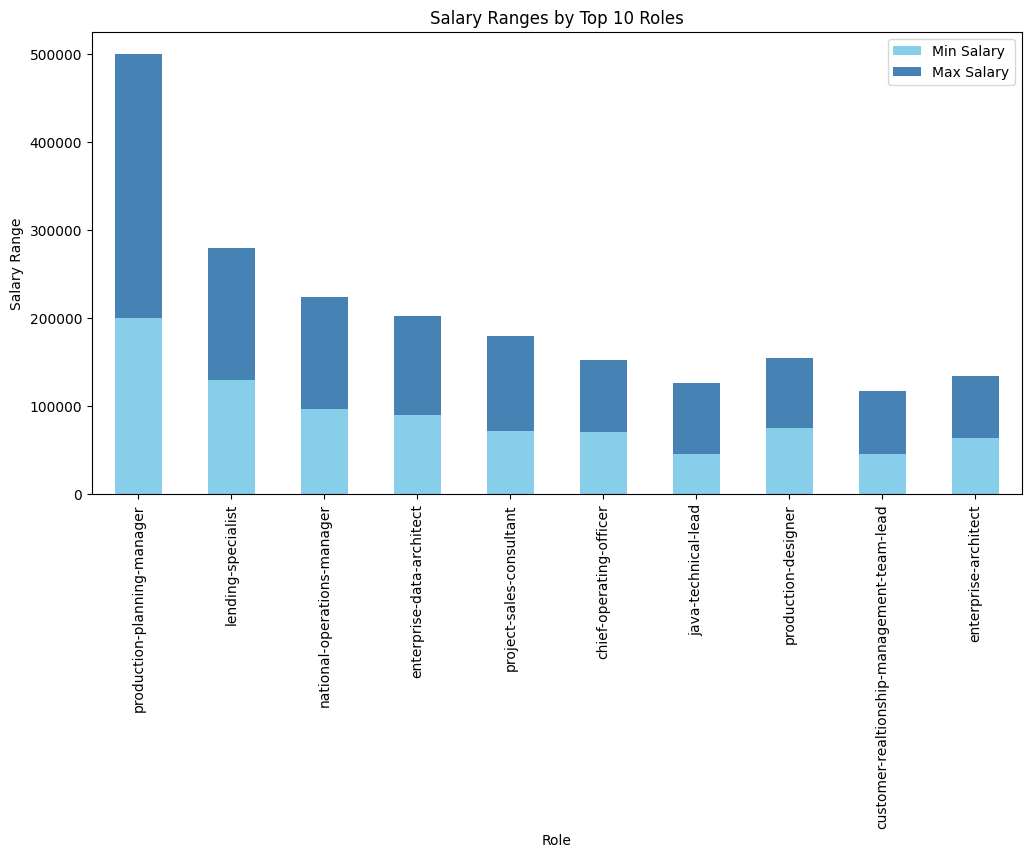

In [60]:
role_salary_range = data.groupby('role')[['min_salary', 'max_salary']].mean().reset_index()
role_salary_range = role_salary_range.sort_values('max_salary', ascending=False).head(10)

plt.figure(figsize=(12, 6))
role_salary_range.set_index('role').plot(kind='bar', stacked=True, figsize=(12, 6), color=['skyblue', 'steelblue'])
plt.title('Salary Ranges by Top 10 Roles')
plt.xlabel('Role')
plt.ylabel('Salary Range')
plt.xticks(rotation=90)
plt.legend(['Min Salary', 'Max Salary'])
plt.show()



This bar chart shows the salary ranges for the top 10 roles, with the light blue portion representing the minimum salary and the darker blue portion indicating the maximum salary.

1. The Production Planning Manager role has the highest maximum salary, significantly higher than the rest.

2. Roles like Lending Specialist and National Operations Manager also have relatively high salary ranges.

3. The roles at the lower end, such as Customer Relationship Management Team Lead and Enterprise Architect, have narrower salary ranges.

4. Employers are offering substantial compensation, especially for more senior, specialized, and leadership-oriented roles.

5. Job seekers with the appropriate skills and experience can expect to command higher salaries in areas like product management, specialist field and operation management.

### Clustering Analysis for Job Roles and Salaries

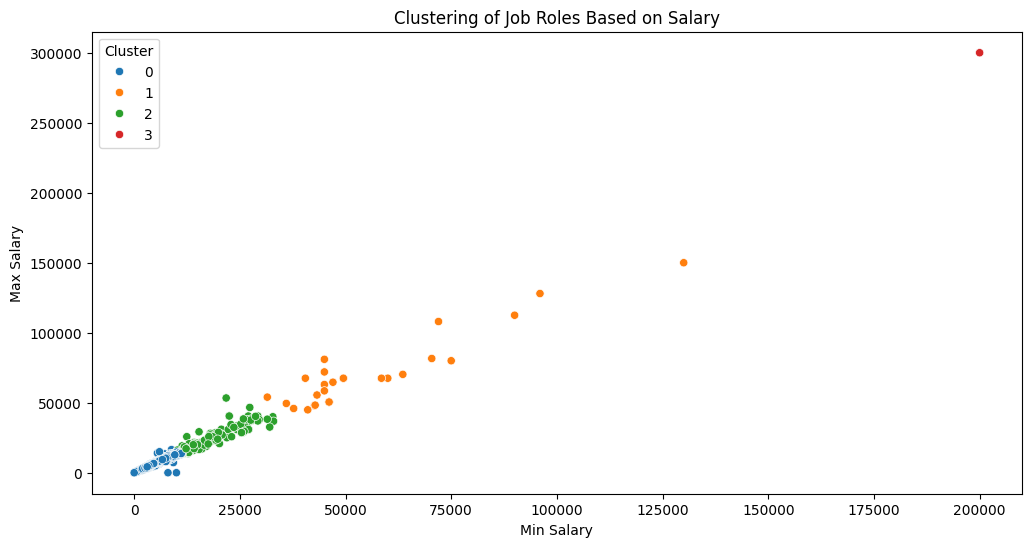

In [61]:
clustering_data = data.groupby('role')[['min_salary', 'max_salary', 'avg_salary']].mean().reset_index()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data[['min_salary', 'max_salary', 'avg_salary']])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(scaled_data)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=clustering_data, x='min_salary', y='max_salary', hue='Cluster', palette='tab10')
plt.title('Clustering of Job Roles Based on Salary')
plt.xlabel('Min Salary')
plt.ylabel('Max Salary')
plt.legend(title='Cluster')
plt.show()

This scatter plot visualizes clusters of job roles based on their minimum and maximum salaries. Clusters are color-coded (blue, orange, green, and red) and represent groupings of roles with similar salary distributions.

1. The blue cluster represents low-salary roles with both minimum and maximum salaries falling under a tight range. Likely include entry-level or less specialized work.
2. Orange cluster includes mid-range salary roles that show more variability. May includes positions that require certain experience or professional skills.
3. The green cluster has higher salaries and greater dispersion between minimum and maximum. Likely include more senior or specialized positions that pay more.
4. The red cluster represents a job with the highest (outlier) salary range. This may include senior management, executives or special positions with exceptionally high pay.
5. The few outliers in the green and orange clusters indicate that there is a wide range of salaries for high-paying positions.

<ipython-input-62-a8435912fe45>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')


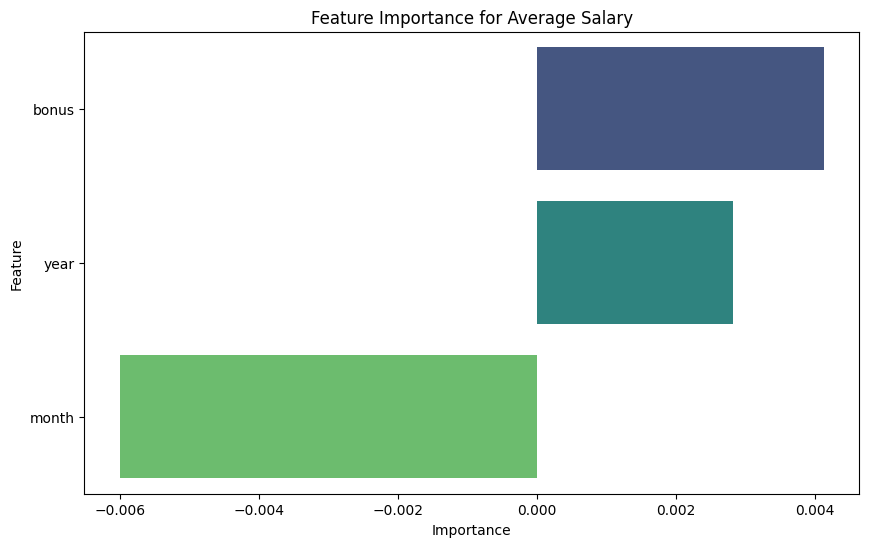

In [62]:
feature_cols = ['bonus', 'year', 'month']
X = data[feature_cols]
y = data['avg_salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Feature importance analysis
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
feature_importances = pd.DataFrame({'Feature': feature_cols, 'Importance': perm_importance.importances_mean})
feature_importances.sort_values('Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance for Average Salary')
plt.show()


This horizontal bar chart highlights the importance of three features—bonus, year, and month—in predicting or determining the average salary.

1. Bonus is the most significant feature influencing average salary, suggesting that variable compensation plays a critical role in salary structure.

2. Year, or years of experience, also has a notable positive influence on salary.

3. Month, or the specific time of year, has a very small but slightly negative impact on average salary.

In summary, bonuses and years of experience are the most critical factors that drive higher average salaries, while the specific month has a negligible effect.

# 4.0 Encoding & Standardization

### Drop unwanted columns
Before encoding, we can drop those unwanted columns that are not necessary for our model training. "listingDate" is only used for trend analysis, so we can drop it since we have already completed the analysis. Similarly, "year", "month", and "avg_salary" were also only created for trend analysis purposes, hence we can drop them. Dropping these columns ensures that we focus only the important features.



In [63]:
data.drop(columns=['listingDate', 'year', 'month', 'avg_salary'],axis=1, inplace=True)


In [64]:
data.dtypes

,0
category,object
subcategory,object
role,object
type,object
salary_missing,bool
min_salary,float64
max_salary,float64
bonus,bool
work_from_home,bool
hybrid,bool


## Modeling
### One-Hot Encoding and Multi-Label Binarization
Categorical columns such as 'category', 'type', and 'state' are one-hot encoded using OneHotEncoder from scikit-learn. This method creates binary columns for each unique value within these categorical columns.

For multi-label data, such as 'education', 'soft_skills', and 'languages', the MultiLabelBinarizer is used to transform these columns into binary format, where each label in a list is represented as a separate column.

After encoding, all encoded columns are concatenated into a single full_transformed_data DataFrame for further analysis.

### Principal Component Analysis (PCA)
To reduce dimensionality while retaining significant variance, PCA is applied to the transformed dataset. A separate PCA model is fitted for each category to capture category-specific variance patterns. The goal is to retain 90% of the variance, allowing for a more efficient and meaningful representation of the data in fewer dimensions. This step helps in improving the performance of clustering algorithms while reducing noise and redundancy in the data.

### K-Means Clustering
After PCA, K-Means CLustering is done by testing a range of k values (from 2 to a maximum of 10 or the number of available samples), and the k that yields the highest silhouette score is selected.

### Subcategory & Role Mapping

After clustering, a mapping is created to associate each cluster with its most common subcategory and role. This mapping helps interpret the clusters by identifying dominant job characteristics within each group. For each cluster, the mode (most frequent value) of the 'subcategory' and 'role' columns is assigned to represent that cluster.

### Model Saving and Final Data Export

The trained models, including K-Means, PCA, encoders, and scalers, are saved using joblib for future use. The final dataset, which includes the assigned cluster labels, is exported as a CSV file (final_data_with_clusters.csv) for data testing.

In [65]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.decomposition import PCA

# Partition the data by category
categories = data['category'].unique()
cluster_results = []
kmeans_models = {}
cluster_to_subcategory_role = {}

# Initialize encoders and scalers
encoder = OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore')
mlb = MultiLabelBinarizer()
scaler = StandardScaler()

# Fit MultiLabelBinarizer
mlb.fit(data['education'].fillna('').apply(lambda x: x if isinstance(x, list) else []))
mlb.fit(data['soft_skills'].fillna('').apply(lambda x: x if isinstance(x, list) else []))
mlb.fit(data['languages'].fillna('').apply(lambda x: x if isinstance(x, list) else []))

# Transform features
education_encoded = mlb.transform(data['education'].fillna('').apply(lambda x: x if isinstance(x, list) else []))
soft_skills_encoded = mlb.transform(data['soft_skills'].fillna('').apply(lambda x: x if isinstance(x, list) else []))
languages_encoded = mlb.transform(data['languages'].fillna('').apply(lambda x: x if isinstance(x, list) else []))

# Fit encoders and scalers
encoded_columns = encoder.fit_transform(data[['category', 'type', 'state']])
scaled_numerical_features = scaler.fit_transform(data[['min_salary', 'max_salary', 'experience']])

# Convert to DataFrames
encoded_columns_df = pd.DataFrame.sparse.from_spmatrix(encoded_columns, columns=encoder.get_feature_names_out(), index=data.index)
education_encoded_df = pd.DataFrame(education_encoded, columns=mlb.classes_, index=data.index)
soft_skills_encoded_df = pd.DataFrame(soft_skills_encoded, columns=mlb.classes_, index=data.index)
languages_encoded_df = pd.DataFrame(languages_encoded, columns=mlb.classes_, index=data.index)
scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=['min_salary', 'max_salary', 'experience'], index=data.index)

# Concatenate all transformed features
full_transformed_data = pd.concat([encoded_columns_df, education_encoded_df, soft_skills_encoded_df, languages_encoded_df, scaled_numerical_df], axis=1)

print(full_transformed_data.columns)

# Loop through categories
category_to_pca = {}

for category in categories:
    print(f"Processing category: {category}")

    # Filter data for the current category
    category_data = full_transformed_data.loc[data['category'] == category]

    # Skip clustering if there are fewer rows than clusters
    if category_data.shape[0] < 2:
        print(f"Skipping clustering for {category} due to insufficient samples.")
        continue

    # Apply PCA separately for each category
    pca = PCA(0.9)  # Retain 90% variance
    category_reduced_data = pca.fit_transform(category_data)

    # Store PCA model for later use
    category_to_pca[category] = pca

    # Determine best k using Silhouette Score
    k_values = range(2, min(11, category_reduced_data.shape[0]))  # Ensure k does not exceed samples
    inertia_values = []
    silhouette_scores = []

    def calculate_metrics(k, data):
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(data)
        return kmeans.inertia_, silhouette_score(data, clusters)

    for k in k_values:
        try:
            inertia, silhouette_avg = calculate_metrics(k, category_reduced_data)
            inertia_values.append(inertia)
            silhouette_scores.append(silhouette_avg)
        except ValueError as e:
            print(f"Error with k={k} for {category}: {e}")
            continue

    # Select best k
    if silhouette_scores:
        best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
    else:
        print(f"Skipping {category} due to no valid k found.")
        continue

    print(f"Best k based on Silhouette Score for {category}: {best_k}")

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    clusters = kmeans.fit_predict(category_reduced_data)

    # Save the KMeans model
    kmeans_models[category] = kmeans

    # Assign clusters to category data
    category_data = data[data['category'] == category].copy()
    category_data.loc[:, 'cluster'] = clusters

    # subcategory & role mapping
    for cluster_label in range(best_k):
        cluster_data = category_data[category_data['cluster'] == cluster_label]
        if not cluster_data.empty:
            subcategory = cluster_data['subcategory'].mode()[0] if not cluster_data['subcategory'].mode().empty else None
            role = cluster_data['role'].mode()[0] if not cluster_data['role'].mode().empty else None
            cluster_to_subcategory_role[(category, cluster_label)] = (subcategory, role)

    cluster_results.append(category_data)

# Combine results
final_data = pd.concat(cluster_results, axis=0)

print(final_data.columns)
print(final_data.head())
print(final_data.tail())

# Save models and encoders
joblib.dump(kmeans_models, 'kmeans_models.pkl')
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(mlb, 'mlb.pkl')
joblib.dump(category_to_pca, 'category_to_pca.pkl')

# Save to CSV
final_data.to_csv('final_data_with_clusters.csv', index=False)


Index(['category_Administration & Office Support',
       'category_Advertising, Arts & Media',
       'category_Banking & Financial Services',
       'category_CEO & General Management',
       'category_Call Centre & Customer Service',
       'category_Community Services & Development', 'category_Construction',
       'category_Consulting & Strategy', 'category_Design & Architecture',
       'category_Education & Training', 'category_Engineering',
       'category_Farming, Animals & Conservation',
       'category_Government & Defence', 'category_Healthcare & Medical',
       'category_Hospitality & Tourism',
       'category_Human Resources & Recruitment',
       'category_Information & Communication Technology',
       'category_Insurance & Superannuation', 'category_Legal',
       'category_Manufacturing, Transport & Logistics',
       'category_Marketing & Communications',
       'category_Mining, Resources & Energy',
       'category_Real Estate & Property',
       'category_Ret

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Sales: 2
Processing category: Banking & Financial Services


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Banking & Financial Services: 2
Processing category: Accounting


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Accounting: 3
Processing category: Insurance & Superannuation


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Insurance & Superannuation: 2
Processing category: Real Estate & Property
Best k based on Silhouette Score for Real Estate & Property: 2
Processing category: Administration & Office Support


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Administration & Office Support: 10
Processing category: Engineering


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Engineering: 2
Processing category: Community Services & Development
Best k based on Silhouette Score for Community Services & Development: 2
Processing category: Advertising, Arts & Media


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Advertising, Arts & Media: 10
Processing category: Farming, Animals & Conservation
Best k based on Silhouette Score for Farming, Animals & Conservation: 10
Processing category: Trades & Services


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Trades & Services: 9
Processing category: Hospitality & Tourism


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Hospitality & Tourism: 10
Processing category: Healthcare & Medical


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Healthcare & Medical: 10
Processing category: Manufacturing, Transport & Logistics


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Manufacturing, Transport & Logistics: 2
Processing category: Mining, Resources & Energy
Best k based on Silhouette Score for Mining, Resources & Energy: 7
Processing category: Consulting & Strategy


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Consulting & Strategy: 10
Processing category: Information & Communication Technology


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Information & Communication Technology: 2
Processing category: Design & Architecture


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Design & Architecture: 6
Processing category: Legal


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Legal: 2
Processing category: Science & Technology
Best k based on Silhouette Score for Science & Technology: 10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Processing category: Marketing & Communications


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Marketing & Communications: 10
Processing category: Retail & Consumer Products


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Retail & Consumer Products: 10
Processing category: CEO & General Management
Best k based on Silhouette Score for CEO & General Management: 2
Processing category: Education & Training


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Education & Training: 10
Processing category: Sport & Recreation
Best k based on Silhouette Score for Sport & Recreation: 7
Processing category: Call Centre & Customer Service


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Call Centre & Customer Service: 9
Processing category: Human Resources & Recruitment


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Human Resources & Recruitment: 8
Processing category: Construction


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Best k based on Silhouette Score for Construction: 2
Processing category: Government & Defence
Best k based on Silhouette Score for Government & Defence: 8
Processing category: Self Employment
Skipping clustering for Self Employment due to insufficient samples.
Index(['category', 'subcategory', 'role', 'type', 'salary_missing',
       'min_salary', 'max_salary', 'bonus', 'work_from_home', 'hybrid',
       'state', 'experience', 'education', 'fresh_graduate', 'languages',
       'soft_skills', 'cluster'],
      dtype='object')
  category                        subcategory                       role  \
0    Sales  Account & Relationship Management      key-account-executive   
1    Sales  Account & Relationship Management         management-trainee   
2    Sales  Account & Relationship Management            sales-executive   
3    Sales  Account & Relationship Management  corporate-sales-executive   
4    Sales  Account & Relationship Management            sales-executive   

        typ

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


## Model Pipeline


In [66]:
# Load trained models and preprocessing tools
kmeans_models = joblib.load('kmeans_models.pkl')
encoder = joblib.load('encoder.pkl')
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
mlb = joblib.load('mlb.pkl')

# Load PCA models per category during training
category_to_pca = joblib.load('category_to_pca.pkl')

def safe_mlb_transform(mlb, data):
    transformed_data = []
    for row in data:
        transformed_row = [item for item in row if item in mlb.classes_]
        transformed_data.append(transformed_row)

    return mlb.transform(transformed_data)

# Function to preprocess input data
def preprocess_input(d, category):
    encoded_columns = encoder.transform(d[['category', 'type', 'state']])
    encoded_columns_df = pd.DataFrame.sparse.from_spmatrix(encoded_columns, columns=encoder.get_feature_names_out(), index=d.index)

    # Multi-label binarization
    education_encoded = safe_mlb_transform(mlb, d['education'].fillna('').apply(lambda x: x if isinstance(x, list) else []))
    education_encoded_df = pd.DataFrame(education_encoded, columns=mlb.classes_, index=d.index)

    soft_skills_encoded = safe_mlb_transform(mlb, d['soft_skills'].fillna('').apply(lambda x: x if isinstance(x, list) else []))
    soft_skills_encoded_df = pd.DataFrame(soft_skills_encoded, columns=mlb.classes_, index=d.index)

    languages_encoded = safe_mlb_transform(mlb, d['languages'].fillna('').apply(lambda x: x if isinstance(x, list) else []))
    languages_encoded_df = pd.DataFrame(languages_encoded, columns=mlb.classes_, index=d.index)

    # Scale numerical features
    scaled_numerical_features =  scaler.transform(d[['min_salary', 'max_salary', 'experience']])
    scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=['min_salary', 'max_salary', 'experience'], index=d.index)

    # Combine all features
    final_data = pd.concat([encoded_columns_df, education_encoded_df, soft_skills_encoded_df, languages_encoded_df, scaled_numerical_df], axis=1)

    # Apply category PCA transformation
    pca = category_to_pca.get(category)
    if pca is None:
        raise ValueError(f"PCA for category '{category}' not found.")

    reduced_data = pca.transform(final_data)

    return reduced_data

# Function to predict subcategory and role
def predict_subcategory_role(input_data):
    category = input_data['category'].iloc[0].strip()
    print(f"Category: {category}")

    if category not in kmeans_models:
        print(f"Category '{category}' not found in kmeans_models")
        return {"subcategory": "Unknown", "role": "Unknown"}

    processed_data = preprocess_input(input_data, category)
    kmeans = kmeans_models[category]
    cluster_label = kmeans.predict(processed_data)[0]

    print(f"Predicted Cluster: {cluster_label}")
    return cluster_to_subcategory_role.get((category, cluster_label), ("Unknown", "Unknown"))

## Visualize clusters for different categories

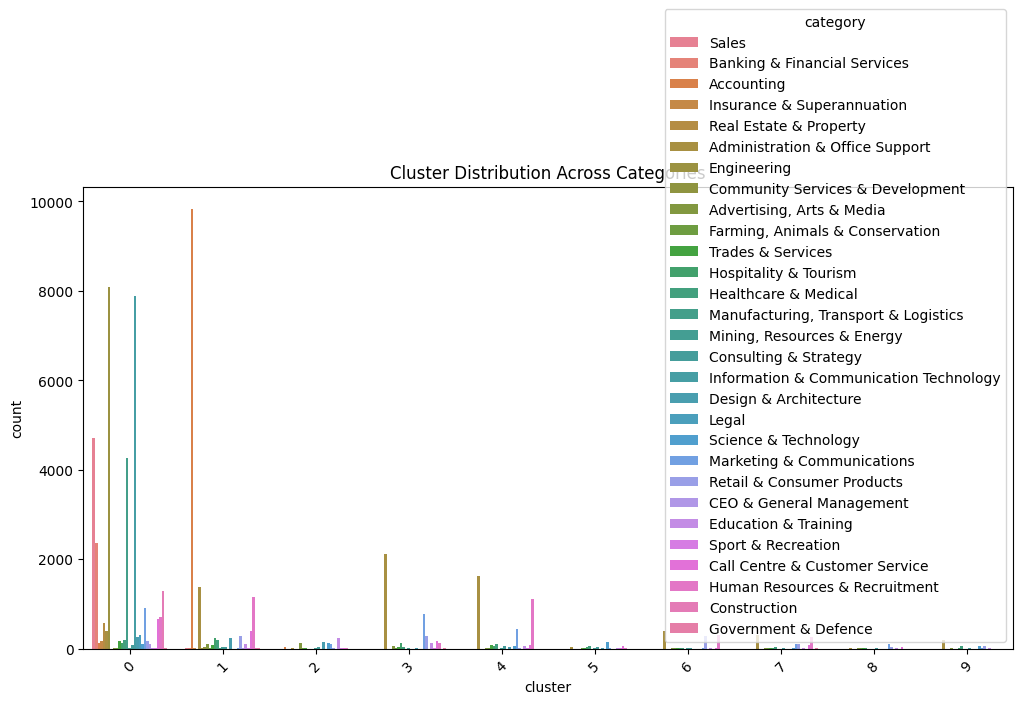

In [67]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=final_data, x='cluster', hue='category')
plt.title("Cluster Distribution Across Categories")
plt.xticks(rotation=45)
plt.show()


## Visualize for "Accounting" clusters
(identify possible key factors affecting the clustering)


In [68]:
accounting_data = final_data[final_data['category'] == 'Accounting']

columns_to_display = [
    'subcategory', 'role', 'type', 'salary_missing', 'min_salary', 'max_salary', 'bonus',
    'work_from_home', 'hybrid', 'state', 'experience', 'education', 'fresh_graduate',
    'languages', 'soft_skills', 'cluster'
]

result = accounting_data.groupby(['category', 'cluster'])[columns_to_display].agg(lambda x: x.mode()[0])

print(result)


                                                subcategory  \
category   cluster                                            
Accounting 0               Financial Accounting & Reporting   
           1        Bookkeeping & Small Practice Accounting   
           2               Financial Accounting & Reporting   

                                 role       type  salary_missing  min_salary  \
category   cluster                                                             
Accounting 0          finance-manager  Full time           False     27000.0   
           1        account-executive  Full time            True      6085.8   
           2        account-executive  Full time            True      6085.8   

                    max_salary  bonus  work_from_home  hybrid  \
category   cluster                                              
Accounting 0          40500.00  False           False   False   
           1           8138.19  False           False   False   
           2           

## Visualize for "Engineering" clusters

In [69]:
engineering_data = final_data[final_data['category'] == 'Engineering']

columns_to_display = [
    'subcategory', 'role', 'type', 'salary_missing', 'min_salary', 'max_salary', 'bonus',
    'work_from_home', 'hybrid', 'state', 'experience', 'education', 'fresh_graduate',
    'languages', 'soft_skills', 'cluster'
]

# Display the grouped clusters for Engineering
result = engineering_data.groupby(['category', 'cluster'])[columns_to_display].agg(lambda x: x.mode()[0])

# Print the result
print(result)


                                           subcategory                role  \
category    cluster                                                          
Engineering 0        Electrical/Electronic Engineering    project-engineer   
            1        Electrical/Electronic Engineering  equipment-engineer   

                          type  salary_missing  min_salary  max_salary  bonus  \
category    cluster                                                             
Engineering 0        Full time            True     4541.91     6299.24  False   
            1        Full time           False   180000.00   250000.00  False   

                     work_from_home  hybrid     state  experience education  \
category    cluster                                                           
Engineering 0                 False   False  Selangor           0  bachelor   
            1                 False   False    Penang           0  bachelor   

                     fresh_graduate         l

## Visualize for "ICT" clusters

In [70]:
ict_data = final_data[final_data['category'] == 'Information & Communication Technology']

columns_to_display = [
    'subcategory', 'role', 'type', 'salary_missing', 'min_salary', 'max_salary', 'bonus',
    'work_from_home', 'hybrid', 'state', 'experience', 'education', 'fresh_graduate',
    'languages', 'soft_skills', 'cluster'
]

result = ict_data.groupby(['category', 'cluster'])[columns_to_display].agg(lambda x: x.mode()[0])

# Print the result
print(result)


                                                                   subcategory  \
category                               cluster                                   
Information & Communication Technology 0                Developers/Programmers   
                                       1        Programme & Project Management   

                                                             role  \
category                               cluster                      
Information & Communication Technology 0        software-engineer   
                                       1           project-leader   

                                                         type  salary_missing  \
category                               cluster                                  
Information & Communication Technology 0            Full time            True   
                                       1        Contract/Temp            True   

                                                min_salary  max_salar

## Testing data

In [71]:
new_data = pd.DataFrame({
    "category": ["Engineering"],
    "type": ["Full time"],
    "min_salary": [4000],
    "max_salary": [10000],
    "bonus": [False],
    "work_from_home": [False],
    "hybrid": [False],
    "state": ["Selangor"],
    "experience": [0],
    "education": [["bachelor"]],
    "fresh_graduate": [True],
    "languages": [["english"]],
    "soft_skills": [["not mentioned"]]
})

# Predict
subcategory, role = predict_subcategory_role(new_data)
print(f"Predicted Subcategory: {subcategory}, Predicted Role: {role}")


Category: Engineering
Predicted Cluster: 0
Predicted Subcategory: Electrical/Electronic Engineering, Predicted Role: project-engineer


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [72]:
new_data = pd.DataFrame({
    "category": ["Engineering"],
    "type": ["Full time"],
    "min_salary": [180000],
    "max_salary": [250000],
    "bonus": [True],
    "work_from_home": [True],
    "hybrid": [True],
    "state": ["Selangor"],
    "experience": [10],
    "education": [["bachelor"]],
    "fresh_graduate": [False],
    "languages": [["English"]],
    "soft_skills": [["Teamwork", "Problem Solving"]]
})

# Predict
subcategory, role = predict_subcategory_role(new_data)
print(f"Predicted Subcategory: {subcategory}, Predicted Role: {role}")



Category: Engineering
Predicted Cluster: 1
Predicted Subcategory: Electrical/Electronic Engineering, Predicted Role: equipment-engineer


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


# Executive Summary

This project analyzes the job market using machine learning to find patterns in job roles, salaries, skills, and hiring trends. The first step is cleaning the data to make sure everything is consistent. Job details such as category, job type, state, education, and skills are convert into numerical using encoding. Salary and experience are scaled to have a fair comparison across different job listings. Feature extraction identified common job requirements, including years of experience, education levels, languages, and soft skills. Data visualization highlighted Accounting, Engineering, and Information and Communication Technology (ICT) as high-demand sectors. Salary analysis showed software engineers having the widest salary range, while fresh graduate-friendly opportunities were limited.

Furthermore, one-hot encoding and multi-label binarization transformed categorical data, while Principal Component Analysis (PCA) reduced data dimension. K-Means clustering is used to group similar job listings. Each job category is analyzed to find the best number of clusters using Silhouette Score. These clusters help identify patterns, such as common job roles, salary ranges, working modes, languages, and required skills. The results are stored and later used to predict job subcategories and roles for new job listings.

To help understand the results, data visualizations are created, showing how job postings are divided into groups, what factors affect clustering, and how salaries and skills different in each role. This helps employers organize job roles better and allows job seekers to understand which skills and qualifications are most needed in the job market.

Using machine learning, this project provides a clear and organized way to study job trends. It helps companies improve hiring strategies and gives job seekers useful information to find the best career opportunities.

# References

- https://www.keycdn.com/support/regex-cheat-sheet
- https://www.pythoncheatsheet.org/cheatsheet/regular-expressions#regex-symbols